# ICU Hospital Mortality Prediction Calculator Among Patients with Heart Failure (AUC 87%)

# Import functions

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
import numpy as np
sns.set_style("darkgrid")
mpl.rcParams['figure.figsize'] = (20,5)
import random

from sklearn import linear_model

from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression(solver='lbfgs', max_iter=10000000)

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn import svm
from sklearn.metrics import f1_score, roc_auc_score,accuracy_score,confusion_matrix, precision_recall_curve, auc, roc_curve, classification_report, mean_squared_error

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import FunctionTransformer

from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import VotingClassifier

from sklearn.datasets import make_classification

from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error as MSE
# Set seed for reproducibility
SEED = 1

###from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

# Preparing the Data

In [3]:
df = pd.read_csv('HospitalMortality.csv')
df.head()

group      ID  outcome  age  gendera        BMI  hypertensive  \
0      1  125047      0.0   72        1  37.588179             0   
1      1  139812      0.0   75        2        NaN             0   
2      1  109787      0.0   83        2  26.572634             0   
3      1  130587      0.0   43        2  83.264629             0   
4      1  138290      0.0   75        2  31.824842             1   

   atrialfibrillation  CHD with no MI  diabetes  ...  Blood sodium  \
0                   0               0         1  ...    138.750000   
1                   0               0         0  ...    138.888889   
2                   0               0         0  ...    140.714286   
3                   0               0         0  ...    138.500000   
4                   0               0         0  ...    136.666667   

   Blood calcium    Chloride  Anion gap  Magnesium ion     PH  Bicarbonate  \
0       7.463636  109.166667  13.166667       2.618182  7.230    21.166667   
1       8.162500   98.444444  11.444444       1.887500  7.225    33.444444   
2       8.266667  105.857143  10.000000       2.157143  7.268    30.571429   
3       9.476923   92.071429  12.357143       1.942857  7.370    38.571429   
4       8.733333  104.500000  15.166667       1.650000  7.250    22.000000   

   Lactic acid  PCO2  EF  
0          0.5  40.0  55  
1          0.5  78.0  55  
2          0.5  71.5  35  
3          0.6  75.0  55  
4          0.6  50.0  55  

[5 rows x 51 columns]

In [4]:
#Create a second identical data set - this will come in handy as we want to test changes while preparing the dataset
df_1 = pd.read_csv('HospitalMortality.csv')

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1177 entries, 0 to 1176
Data columns (total 51 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   group                     1177 non-null   int64  
 1   ID                        1177 non-null   int64  
 2   outcome                   1176 non-null   float64
 3   age                       1177 non-null   int64  
 4   gendera                   1177 non-null   int64  
 5   BMI                       962 non-null    float64
 6   hypertensive              1177 non-null   int64  
 7   atrialfibrillation        1177 non-null   int64  
 8   CHD with no MI            1177 non-null   int64  
 9   diabetes                  1177 non-null   int64  
 10  deficiencyanemias         1177 non-null   int64  
 11  depression                1177 non-null   int64  
 12  Hyperlipemia              1177 non-null   int64  
 13  Renal failure             1177 non-null   int64  
 14  COPD    

In [6]:
#Group 1 & 2 were used to differentiate the derivation and validation group 
print(df["group"].unique()) 

[1 2]


Group variable not needed as we will use our own train-test dataset later in this notebook.

In [7]:
#Drop unccessary / extrenuous variables 
df.drop('ID', axis = 1, inplace = True)
df.drop('group', axis = 1, inplace = True)
print(df.info())

df_1.drop('ID', axis = 1, inplace = True)
df_1.drop('group', axis = 1, inplace = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1177 entries, 0 to 1176
Data columns (total 49 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   outcome                   1176 non-null   float64
 1   age                       1177 non-null   int64  
 2   gendera                   1177 non-null   int64  
 3   BMI                       962 non-null    float64
 4   hypertensive              1177 non-null   int64  
 5   atrialfibrillation        1177 non-null   int64  
 6   CHD with no MI            1177 non-null   int64  
 7   diabetes                  1177 non-null   int64  
 8   deficiencyanemias         1177 non-null   int64  
 9   depression                1177 non-null   int64  
 10  Hyperlipemia              1177 non-null   int64  
 11  Renal failure             1177 non-null   int64  
 12  COPD                      1177 non-null   int64  
 13  heart rate                1164 non-null   float64
 14  Systolic

In [8]:
#Check for missing variables 
df.isna().sum()

outcome                       1
age                           0
gendera                       0
BMI                         215
hypertensive                  0
atrialfibrillation            0
CHD with no MI                0
diabetes                      0
deficiencyanemias             0
depression                    0
Hyperlipemia                  0
Renal failure                 0
COPD                          0
heart rate                   13
Systolic blood pressure      16
Diastolic blood pressure     16
Respiratory rate             13
temperature                  19
SP O2                        13
Urine output                 36
hematocrit                    0
RBC                           0
MCH                           0
MCHC                          0
MCV                           0
RDW                           0
Leucocyte                     0
Platelets                     0
Neutrophils                 144
Basophils                   259
Lymphocyte                  145
PT      

In [9]:
#List the variables with missing data
df.columns[df.isna().any()].tolist()

['outcome',
 'BMI',
 'heart rate',
 'Systolic blood pressure',
 'Diastolic blood pressure',
 'Respiratory rate',
 'temperature',
 'SP O2',
 'Urine output',
 'Neutrophils',
 'Basophils',
 'Lymphocyte',
 'PT',
 'INR',
 'Creatine kinase',
 'glucose',
 'Blood calcium',
 'PH',
 'Lactic acid',
 'PCO2']

All independent variables with null are continuous.

In [10]:
#Drop null row in target column
df = df.dropna(subset=['outcome']) 

df_1 = df.dropna(subset=['outcome']) 

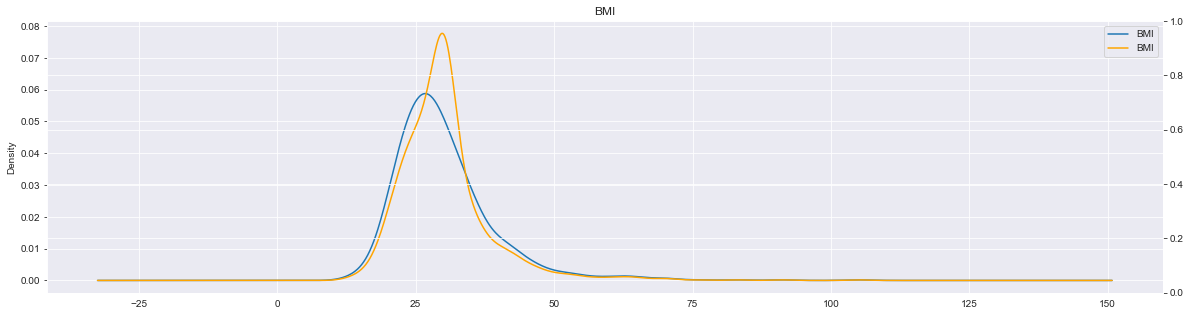

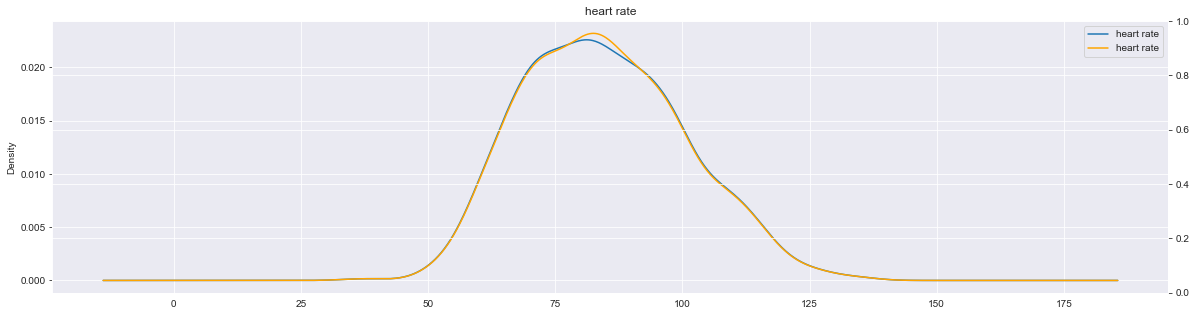

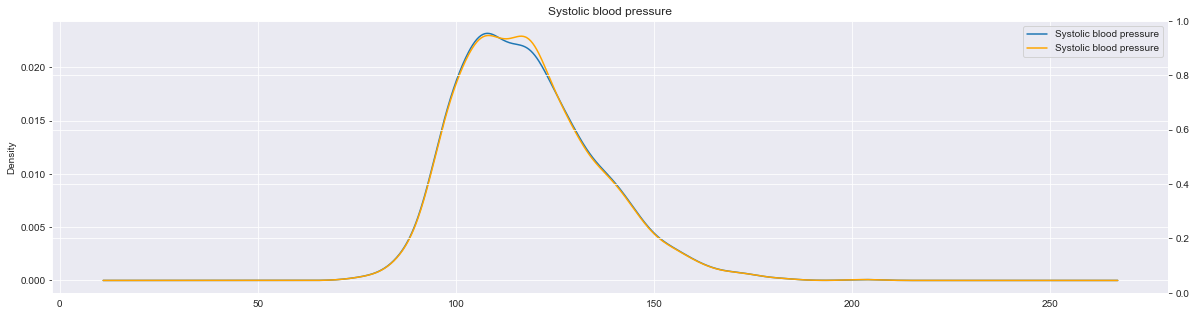

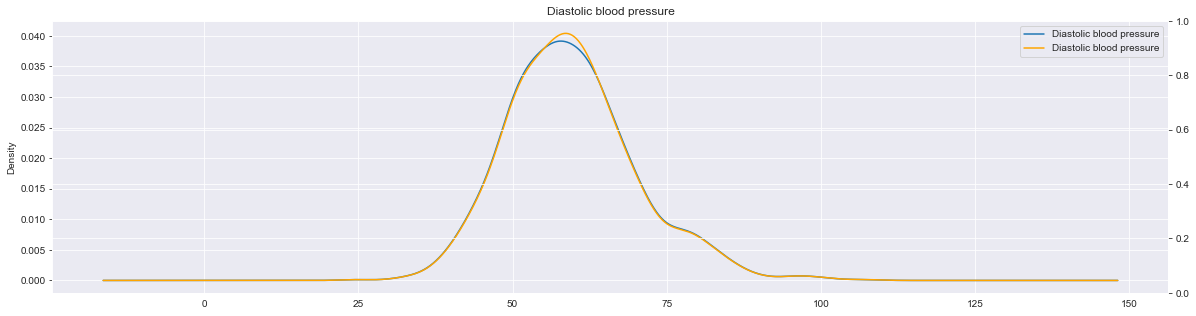

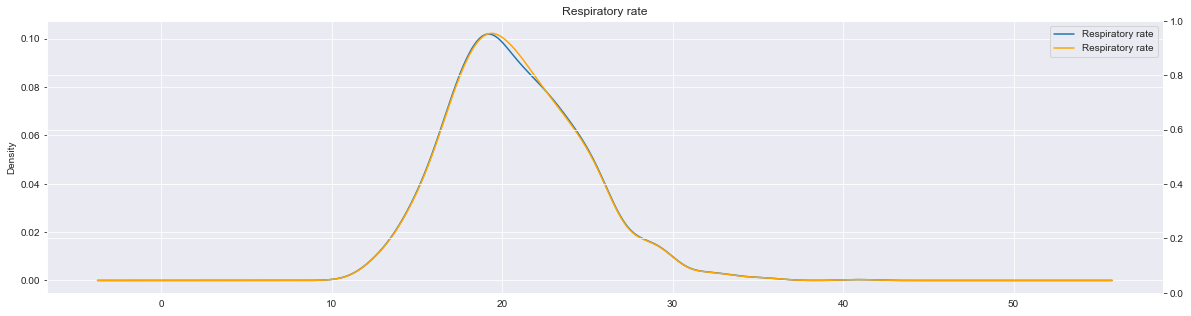

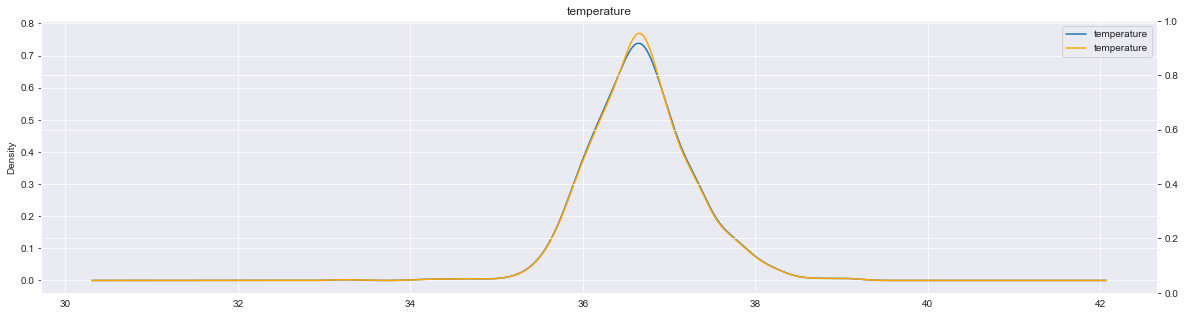

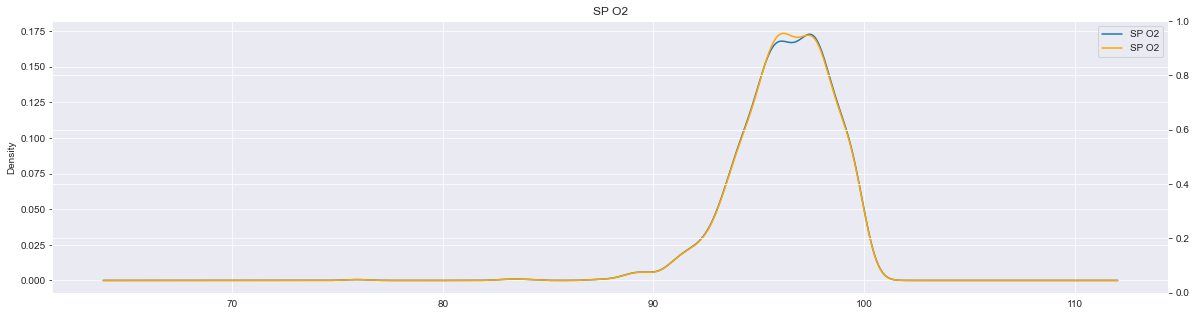

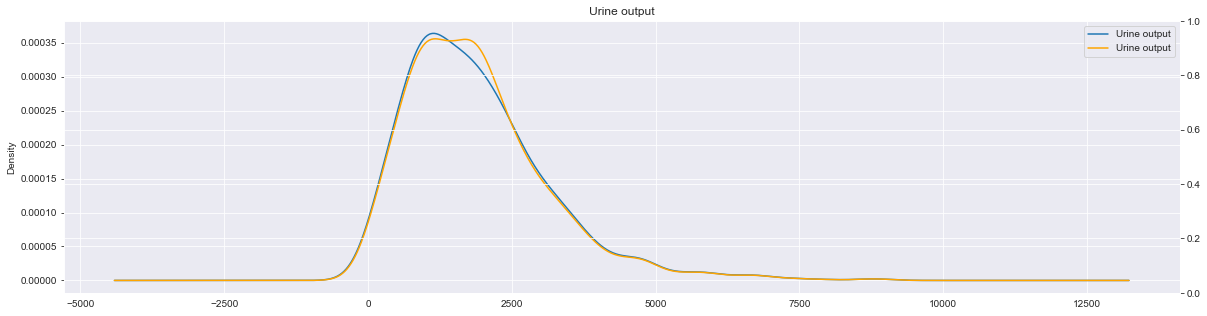

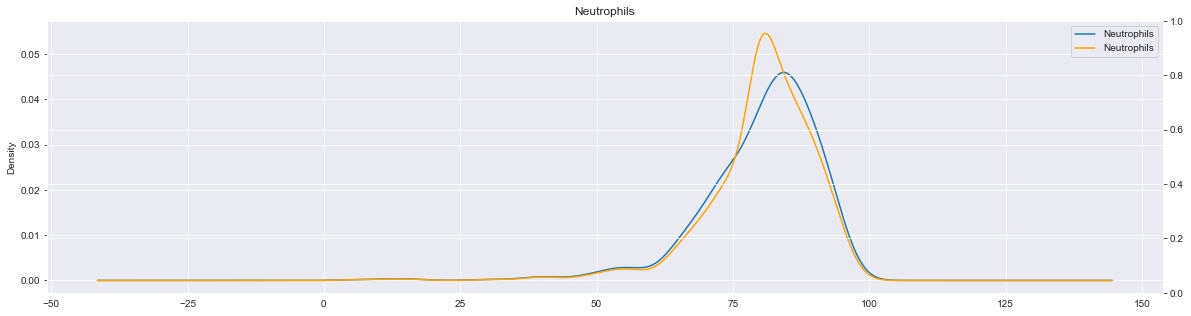

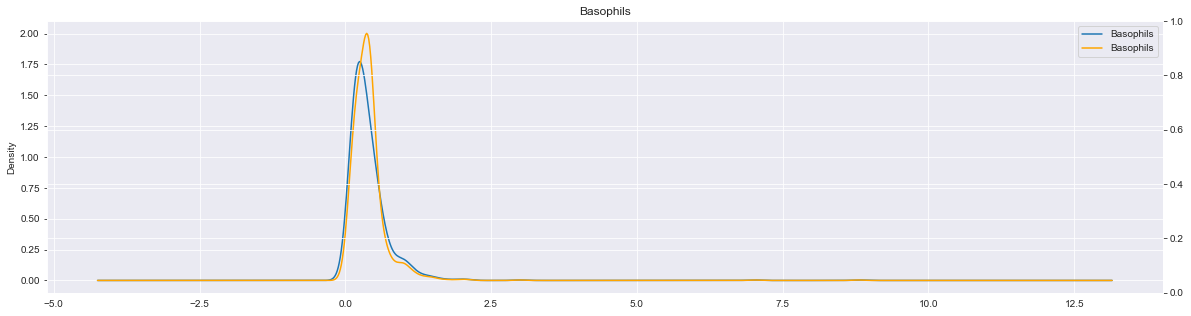

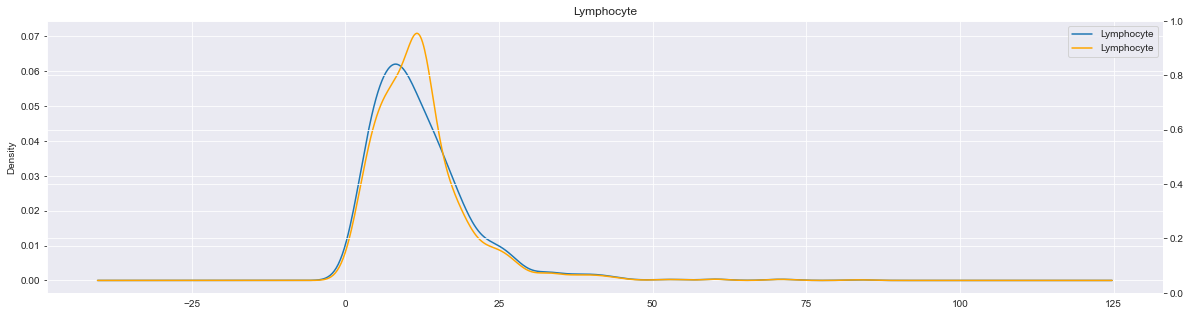

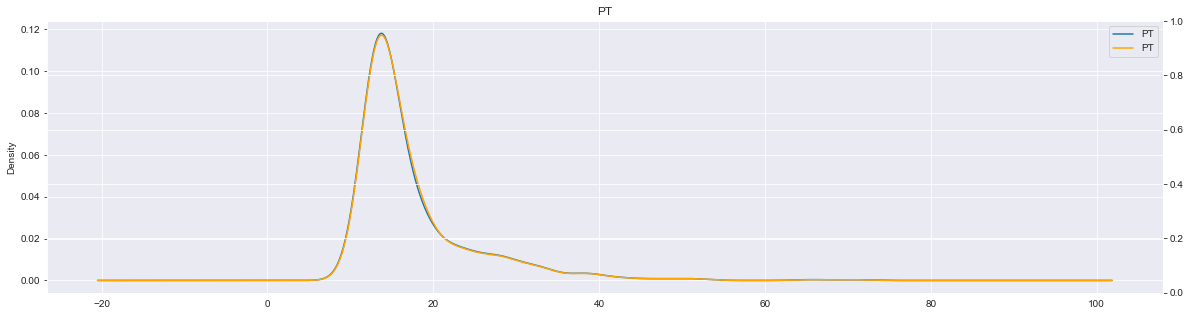

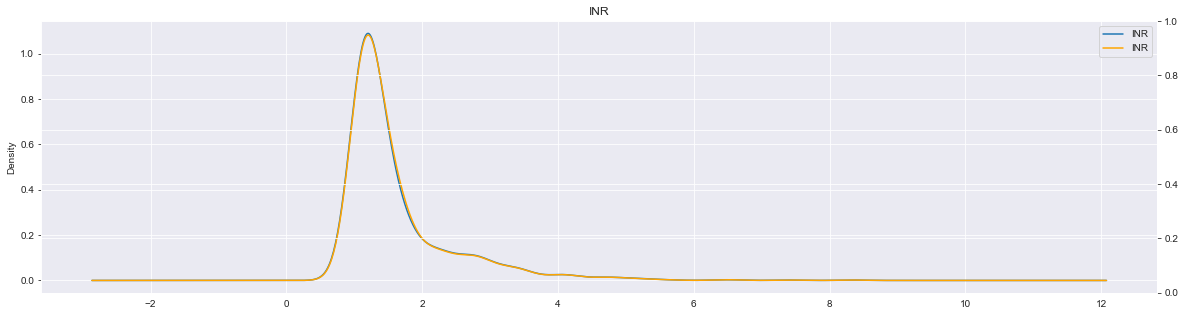

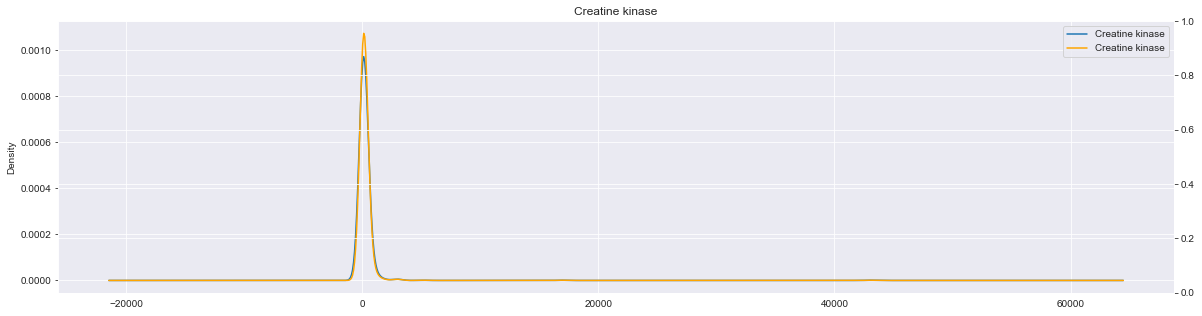

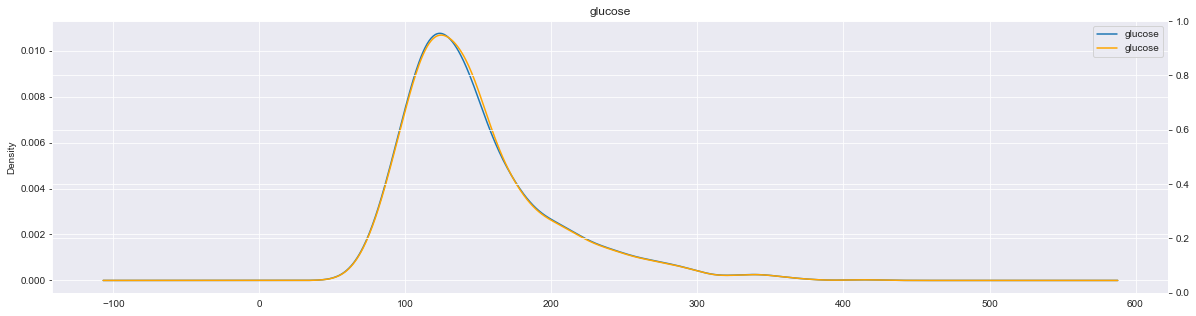

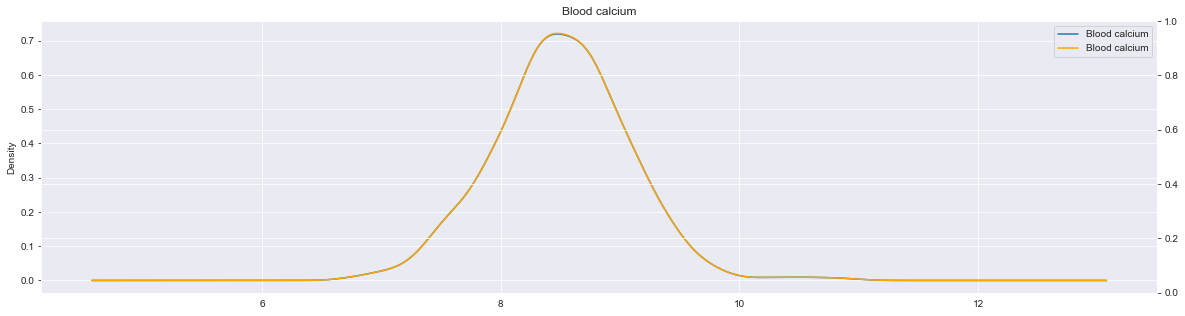

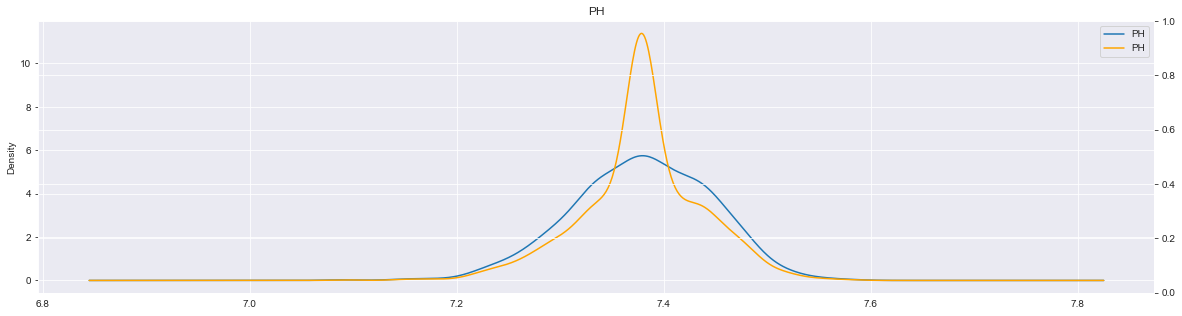

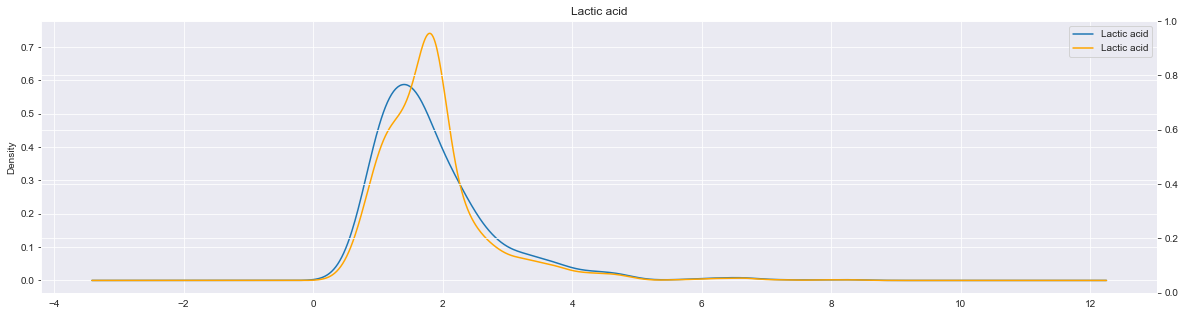

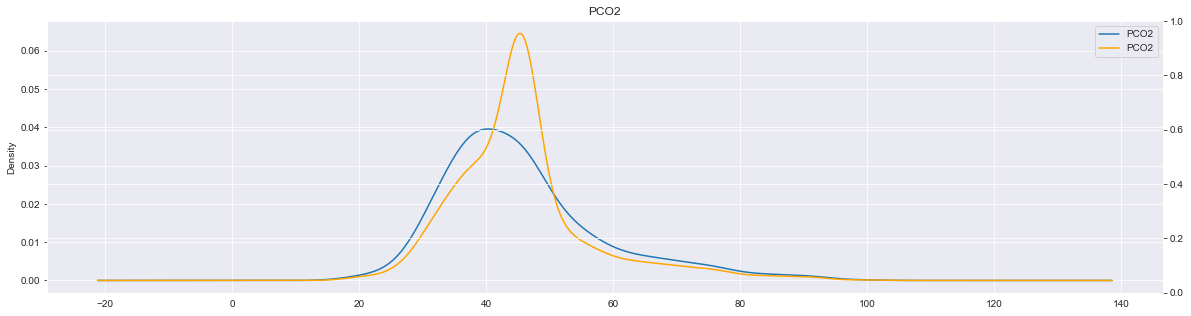

In [11]:
#Replace null value of continuous variables with the mean. Then compare the imputed value vs. the actual value in the data set
df_select = df[['BMI','heart rate','Systolic blood pressure','Diastolic blood pressure','Respiratory rate',
                  'temperature','SP O2','Urine output','Neutrophils','Basophils','Lymphocyte','PT','INR','Creatine kinase',
                  'glucose','Blood calcium','PH','Lactic acid','PCO2']]
df_imputed = df.fillna(df[['BMI','heart rate','Systolic blood pressure','Diastolic blood pressure','Respiratory rate',
                  'temperature','SP O2','Urine output','Neutrophils','Basophils','Lymphocyte','PT','INR','Creatine kinase',
                  'glucose','Blood calcium','PH','Lactic acid','PCO2']].mean())

ListOfVariables = ['BMI','heart rate','Systolic blood pressure','Diastolic blood pressure','Respiratory rate',
                  'temperature','SP O2','Urine output','Neutrophils','Basophils','Lymphocyte','PT','INR','Creatine kinase',
                  'glucose','Blood calcium','PH','Lactic acid','PCO2']
    
for item in ListOfVariables:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    first_axis = df_select[item].plot(kind='kde', ax=ax) #Looping through every item in the dataframe.
    second_axis = first_axis.twinx() #The Twinx function to ensure we share the X-Axis for both plots
    second_axis= df_imputed[item].plot(kind='kde', ax=ax, color = 'orange')
    lines, labels = ax.get_legend_handles_labels()
    ax.legend(lines, labels, loc='best')   
    plt.title(item)
    plt.show()

Imputed values using mean replacement of missing values came close to original distribution for Heart Rate, Systolic Blood Pressure, Diastolic blood prssure, respiratory rate, temperature, SPo2, Urine output, PT, INR, Creatinine Kinase, glucose, blood calcium.

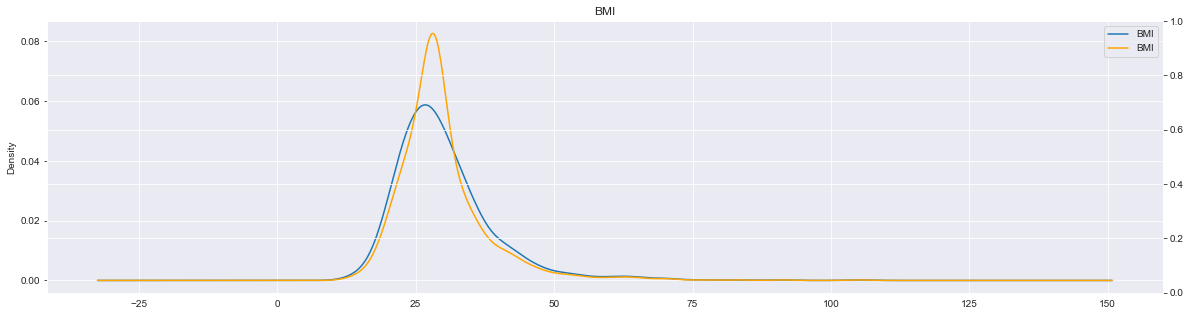

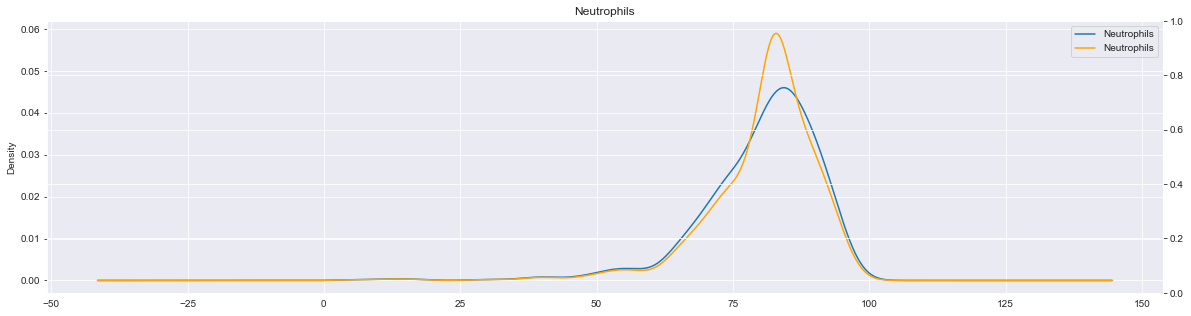

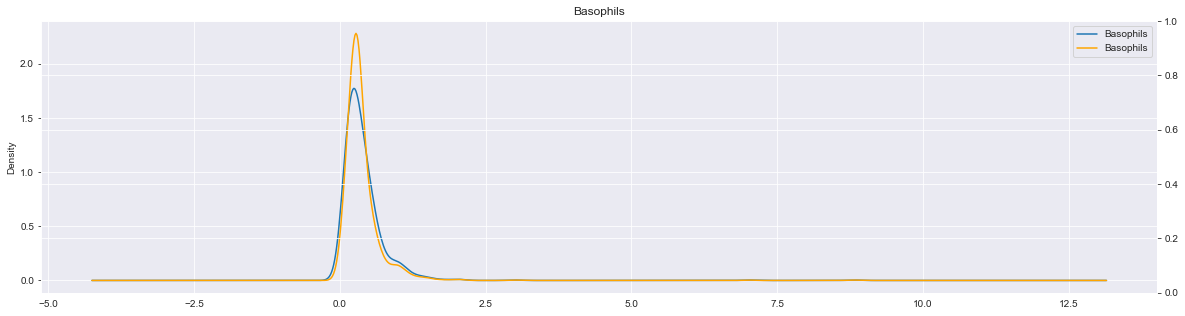

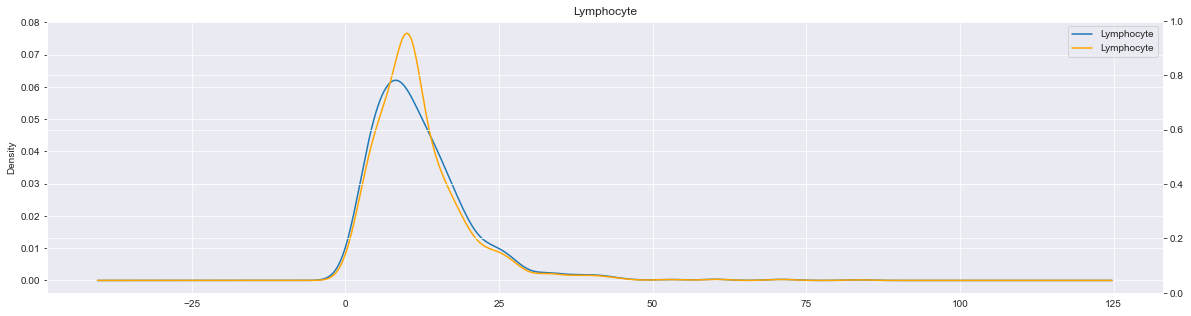

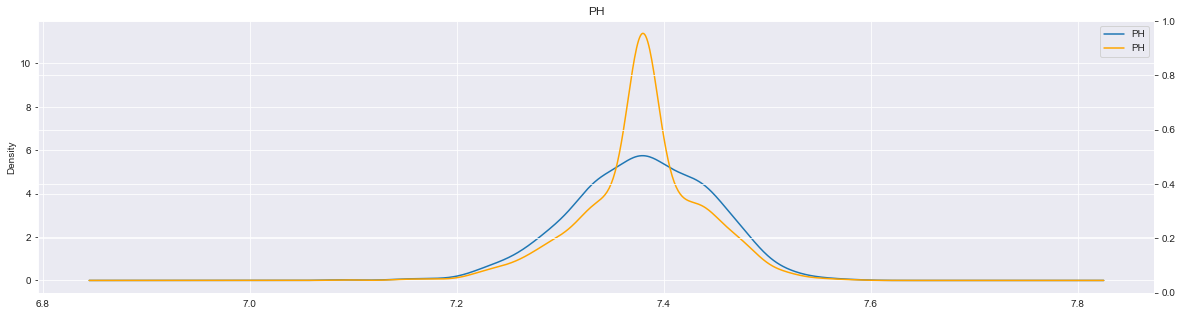

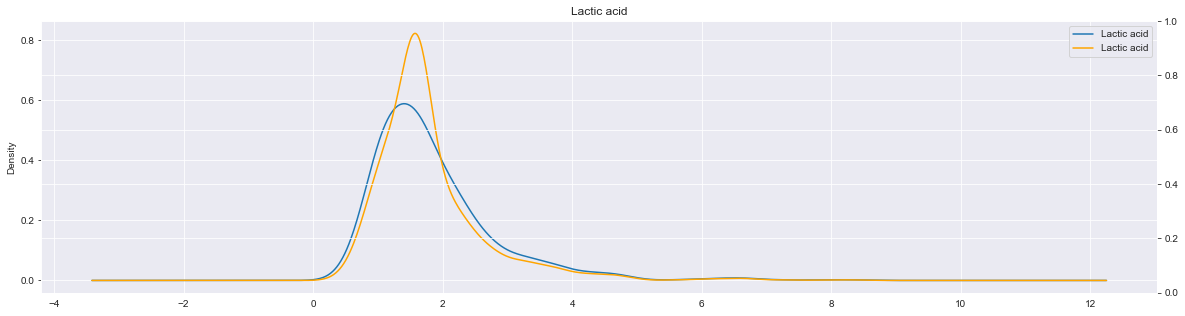

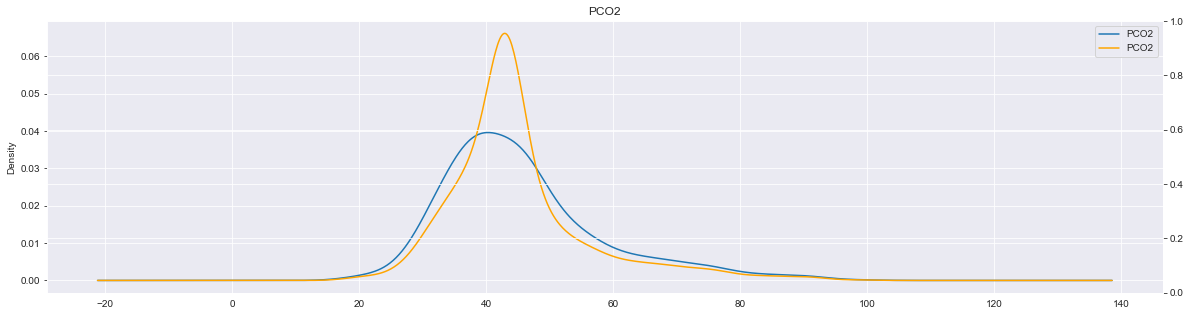

In [12]:
#Imputed mean values for BMI, Neutrophils, basophils, lumphocytes, pH, Lactic Acid, PCO2 is not close to actual value, use median value to replace Null####   
df_select2 = df[['BMI','Neutrophils','Basophils','Lymphocyte','PH','Lactic acid','PCO2']]
df_imputed2 = df.fillna(df[['BMI','Neutrophils','Basophils','Lymphocyte','PH','Lactic acid','PCO2']].median())

ListOfVariables2 = ['BMI','Neutrophils','Basophils','Lymphocyte','PH','Lactic acid','PCO2']
    
for item in ListOfVariables2:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    first_axis = df_select2[item].plot(kind='kde', ax=ax) #Looping through every item in the dataframe.
    second_axis = first_axis.twinx() #The Twinx function is used to ensure we share the X-Axis for both plots
    second_axis= df_imputed2[item].plot(kind='kde', ax=ax, color = 'orange')
    lines, labels = ax.get_legend_handles_labels()
    ax.legend(lines, labels, loc='best')   
    plt.title(item)
    plt.show()

Imputed values using median replacement of missing values did not come close to original distribution, consider using random number replacement.

In [13]:
#Use random values to replace remaining null values

#First: Replace null values with the random value in the dataframe copy (df_1)
ListOfVariables3 = df_1[['BMI','Neutrophils','Basophils','Lymphocyte','PH','Lactic acid','PCO2']]

for item in ListOfVariables3:  
    index = df_1[df_1[item].isna()].index #Create an index with all the rows where variable is null
    value = np.random.normal(loc=df_1[item].mean(), scale=df_1[item].std(), size=df_1[item].isna().sum()) #Creates a list of values, randomized, based on a normal distribution using your variable output in the df dataframe
    df_1[item] = df_1[item].fillna(pd.Series(value, index=index)) #Fills the null values in variable using the values from the normal distribution based off the existing variable output. This way the existing distribution won't change, and it's all randomized.

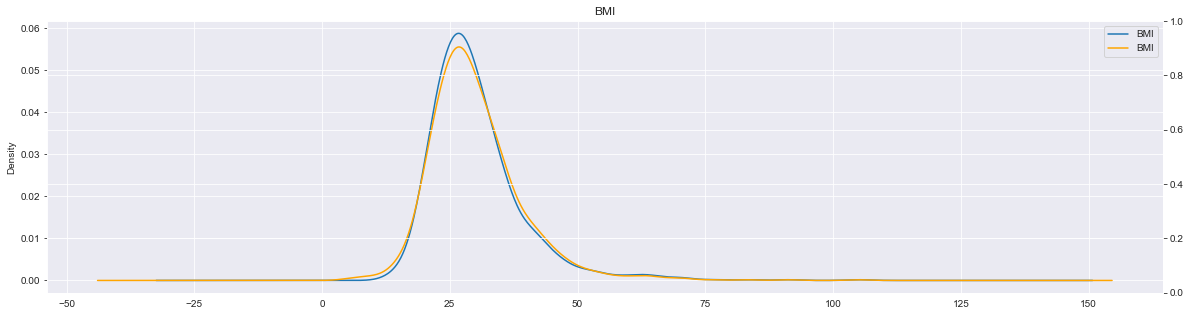

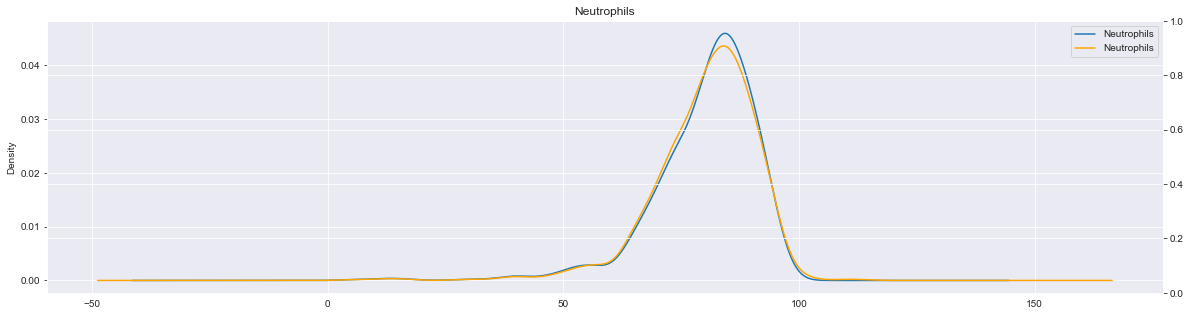

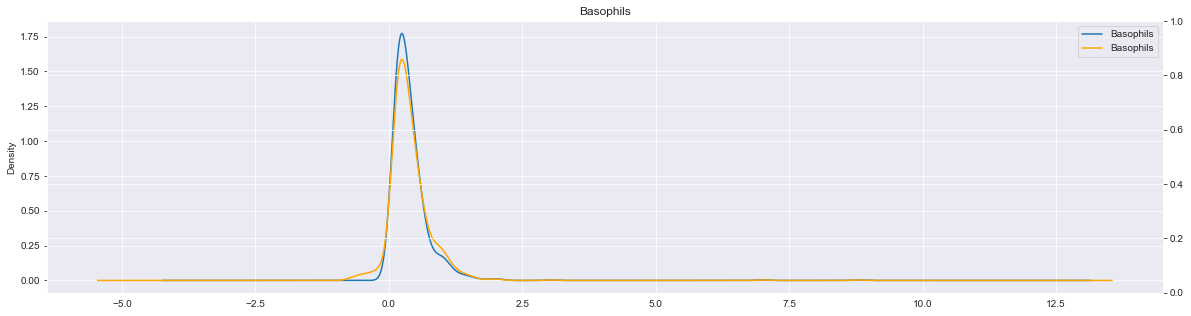

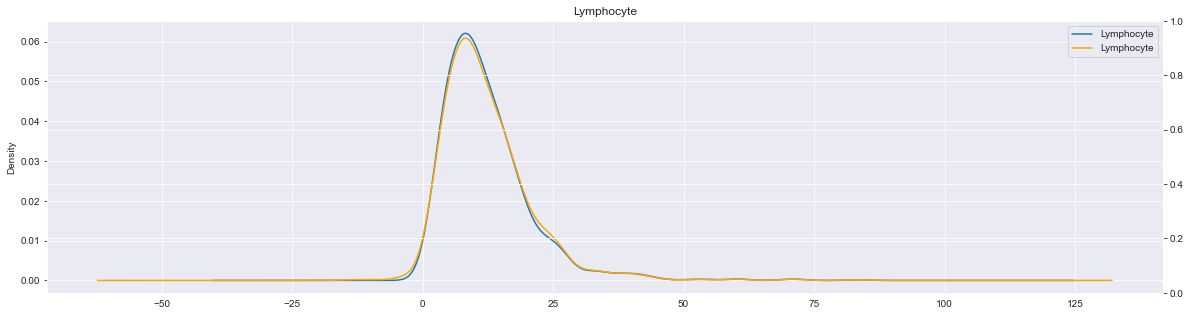

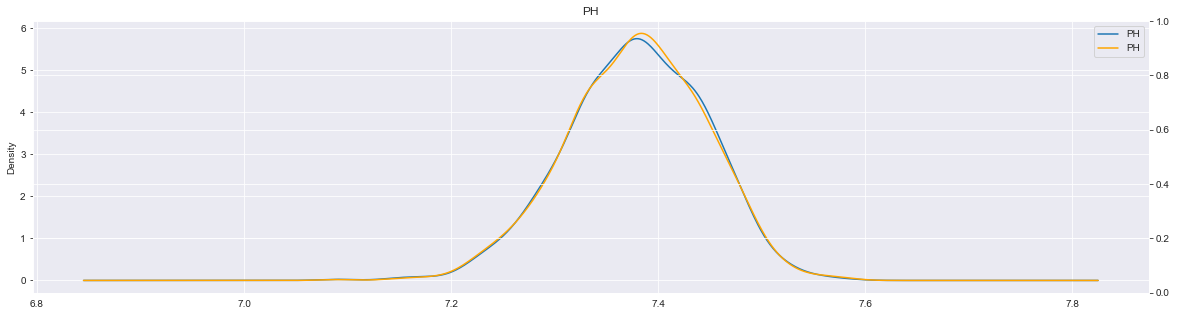

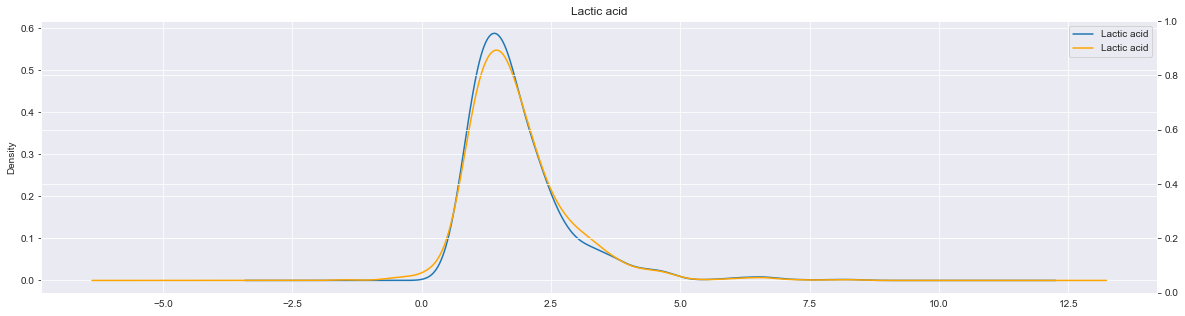

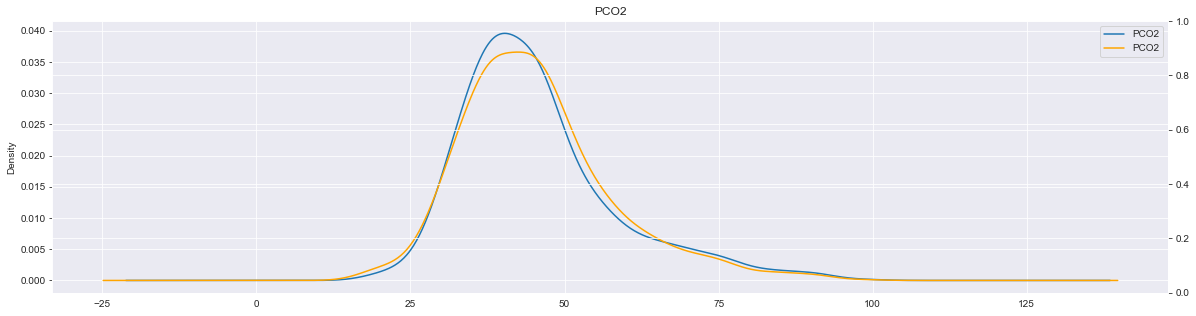

In [14]:
#Second: Then compare the imputed value (using random values to substitute for null) vs. the actual value in the data set
df_select4 = df[['BMI','Neutrophils','Basophils','Lymphocyte','PH','Lactic acid','PCO2']]
df_imputed4 = df_1[['BMI','Neutrophils','Basophils','Lymphocyte','PH','Lactic acid','PCO2']]
ListOfVariables4 = ['BMI','Neutrophils','Basophils','Lymphocyte','PH','Lactic acid','PCO2'] 

for item in ListOfVariables4:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    first_axis = df_select4[item].plot(kind='kde', ax=ax) #Looping through every item in the dataframe.
    second_axis = first_axis.twinx() #The Twinx function is used to ensure we share the X-Axis for both plots
    second_axis= df_imputed4[item].plot(kind='kde', ax=ax, color = 'orange')
    lines, labels = ax.get_legend_handles_labels()
    ax.legend(lines, labels, loc='best')   
    plt.title(item)
    plt.show()

In [15]:
#Fill null value in continuous variable with mean or random value as tested above
df.fillna(df[['heart rate','Systolic blood pressure','Diastolic blood pressure','Respiratory rate',
                  'temperature','SP O2','Urine output','PT','INR','Creatine kinase',
                  'glucose','Blood calcium']].mean(), inplace = True)

df.isna().sum()

outcome                       0
age                           0
gendera                       0
BMI                         214
hypertensive                  0
atrialfibrillation            0
CHD with no MI                0
diabetes                      0
deficiencyanemias             0
depression                    0
Hyperlipemia                  0
Renal failure                 0
COPD                          0
heart rate                    0
Systolic blood pressure       0
Diastolic blood pressure      0
Respiratory rate              0
temperature                   0
SP O2                         0
Urine output                  0
hematocrit                    0
RBC                           0
MCH                           0
MCHC                          0
MCV                           0
RDW                           0
Leucocyte                     0
Platelets                     0
Neutrophils                 144
Basophils                   259
Lymphocyte                  145
PT      

In [16]:
#loop to replace null value with random value on actual dataset
ListOfVariables5 = df[['BMI','Neutrophils','Basophils','Lymphocyte','PH','Lactic acid','PCO2']]

for item in ListOfVariables5:  
    index = df[df[item].isna()].index #Create an index with all the rows where variable is null
    value = np.random.normal(loc=df[item].mean(), scale=df[item].std(), size=df[item].isna().sum()) #Creates a list of values, randomized, based on a normal distribution using your variable output in the df dataframe
    df[item] = df[item].fillna(pd.Series(value, index=index)) #Fills the null values in variable using the values from the normal distribution based off the existing variable output. This way the existing distribution won't change, and it's all randomized.
    
df.isna().sum()

outcome                     0
age                         0
gendera                     0
BMI                         0
hypertensive                0
atrialfibrillation          0
CHD with no MI              0
diabetes                    0
deficiencyanemias           0
depression                  0
Hyperlipemia                0
Renal failure               0
COPD                        0
heart rate                  0
Systolic blood pressure     0
Diastolic blood pressure    0
Respiratory rate            0
temperature                 0
SP O2                       0
Urine output                0
hematocrit                  0
RBC                         0
MCH                         0
MCHC                        0
MCV                         0
RDW                         0
Leucocyte                   0
Platelets                   0
Neutrophils                 0
Basophils                   0
Lymphocyte                  0
PT                          0
INR                         0
NT-proBNP 

In [17]:
##Export clean data
df.to_csv(r'C:\Users\J\Desktop\Hospital Mortality Edited.csv')

In [18]:
#Size of data after cleaning
population_size = len(df)
print(population_size)

1176


<AxesSubplot:xlabel='outcome', ylabel='count'>

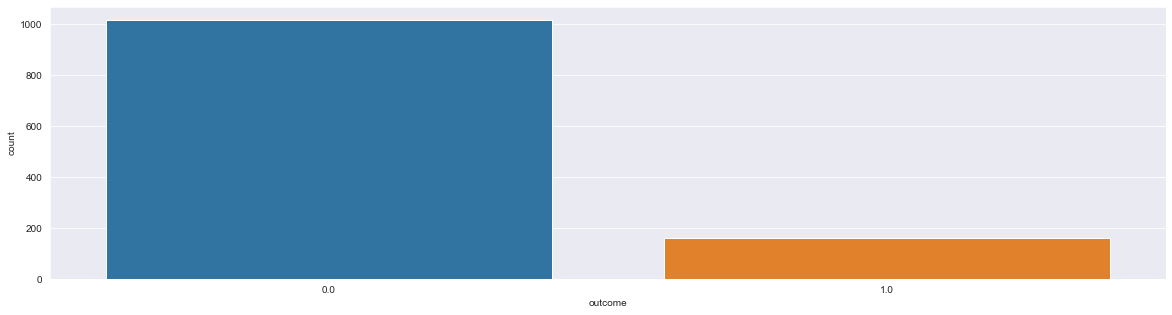

In [20]:
#outcome count
sns.countplot(df['outcome'])

# Exploratory data analysis

In [ ]:
sns.pairplot(df)
plt.show()

<AxesSubplot:>

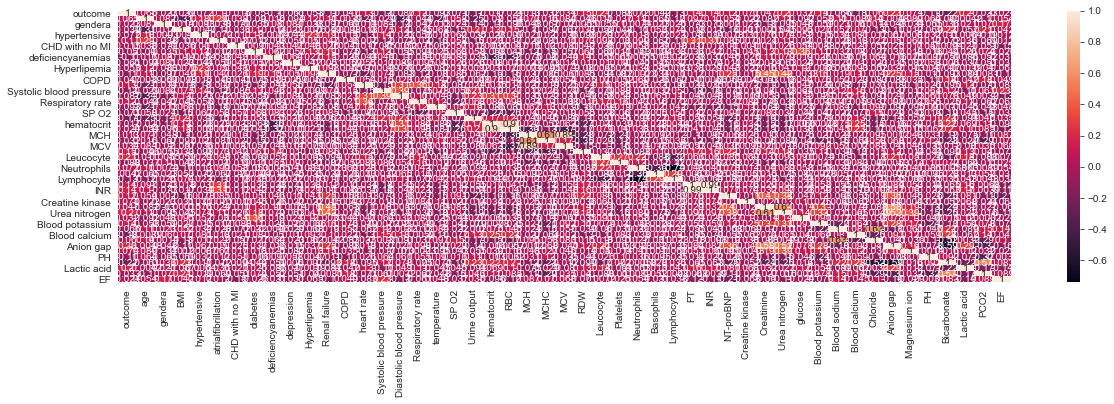

In [19]:
#Heat map to see which variables are most correlated with outcome
sns.heatmap(df.corr(), annot=True) 

In [26]:
df.corr()

outcome       age   gendera       BMI  \
outcome                   1.000000  0.064510 -0.022690 -0.051859   
age                       0.064510  1.000000  0.082355 -0.310056   
gendera                  -0.022690  0.082355  1.000000  0.034478   
BMI                      -0.051859 -0.310056  0.034478  1.000000   
hypertensive             -0.072441  0.176768  0.009342 -0.035702   
atrialfibrillation        0.100975  0.291674 -0.037798 -0.086649   
CHD with no MI           -0.014694  0.037776 -0.079474 -0.037094   
diabetes                 -0.049997 -0.089836 -0.034932  0.115543   
deficiencyanemias        -0.099513  0.015511  0.080283 -0.007546   
depression               -0.060883 -0.094358  0.081129  0.024178   
Hyperlipemia             -0.053466  0.115388 -0.038250 -0.000456   
Renal failure            -0.108500  0.111603 -0.097085 -0.025560   
COPD                     -0.047324 -0.003887 -0.069346 -0.006684   
heart rate                0.129301 -0.209281 -0.013634 -0.006560   
Systolic blood pressure  -0.132370 -0.028966  0.084385  0.070112   
Diastolic blood pressure -0.087083 -0.343198 -0.133704  0.125725   
Respiratory rate          0.116610 -0.044012 -0.042087 -0.039343   
temperature              -0.092502 -0.211753 -0.012792  0.073035   
SP O2                    -0.070943  0.057765  0.024078 -0.142840   
Urine output             -0.171344 -0.249769 -0.138640  0.215178   
hematocrit               -0.016533 -0.020027 -0.114135  0.088773   
RBC                      -0.023992 -0.053903 -0.095692  0.118089   
MCH                       0.013387  0.076997 -0.048230 -0.109253   
MCHC                     -0.031885  0.016296 -0.067104 -0.084122   
MCV                       0.034144  0.083709 -0.020439 -0.083498   
RDW                       0.148089 -0.046086  0.005546  0.064326   
Leucocyte                 0.208274  0.011299 -0.005539 -0.067417   
Platelets                -0.088465 -0.037318  0.101956 -0.069261   
Neutrophils               0.059596  0.094972  0.008838 -0.077756   
Basophils                -0.020796 -0.059023 -0.030000  0.036014   
Lymphocyte               -0.131708 -0.099573  0.042361  0.084305   
PT                        0.139738  0.097074 -0.072994  0.001035   
INR                       0.143866  0.099571 -0.072860  0.007376   
NT-proBNP                 0.121075  0.054391  0.002019 -0.135258   
Creatine kinase           0.070924 -0.022031  0.023343  0.032808   
Creatinine                0.046717 -0.082458 -0.131586  0.025943   
Urea nitrogen             0.203024  0.106708 -0.094508 -0.000052   
glucose                   0.032227 -0.092175  0.048438  0.092667   
Blood potassium           0.136940 -0.057845 -0.059237  0.033158   
Blood sodium             -0.066366  0.105644  0.022804  0.039377   
Blood calcium            -0.184059 -0.008923  0.059657  0.073378   
Chloride                  0.059834  0.139260  0.001392 -0.143939   
Anion gap                 0.229676 -0.004764 -0.047598 -0.083132   
Magnesium ion             0.074033  0.088651 -0.034438  0.058119   
PH                       -0.109389  0.086932 -0.046985 -0.083693   
Bicarbonate              -0.222650 -0.061097  0.036335  0.221152   
Lactic acid               0.216924  0.012030  0.000133 -0.069484   
PCO2                     -0.037592 -0.081664  0.041327  0.181151   
EF                       -0.024138  0.054138  0.172472  0.031073   

                          hypertensive  atrialfibrillation  CHD with no MI  \
outcome                      -0.072441            0.100975       -0.014694   
age                           0.176768            0.291674        0.037776   
gendera                       0.009342           -0.037798       -0.079474   
BMI                          -0.035702           -0.086649       -0.037094   
hypertensive                  1.000000            0.007244        0.010205   
atrialfibrillation            0.007244            1.000000       -0.003687   
CHD with no MI                0.010205           -0.003687        1.000000   
di

### Continuous Variable Plot

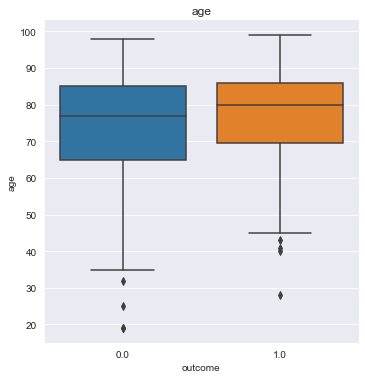

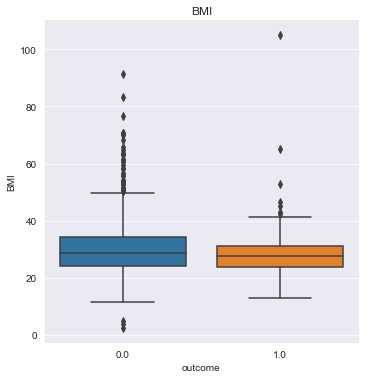

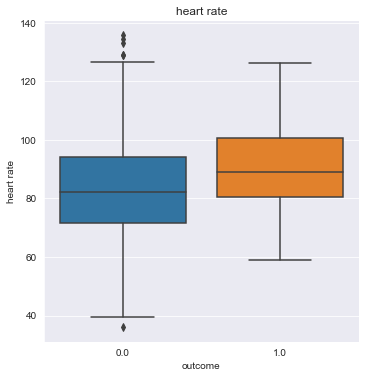

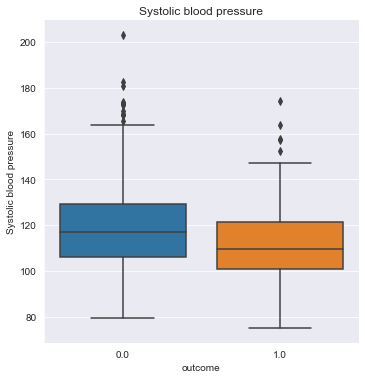

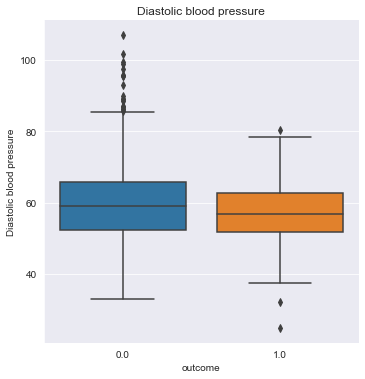

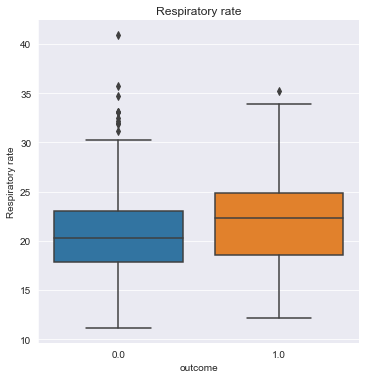

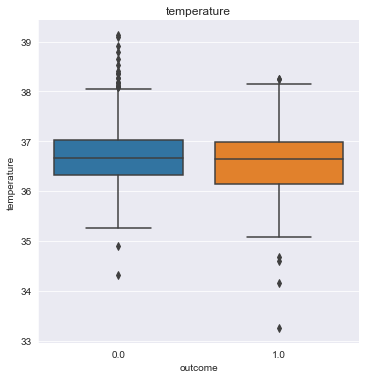

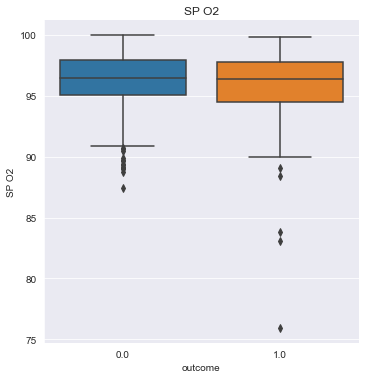

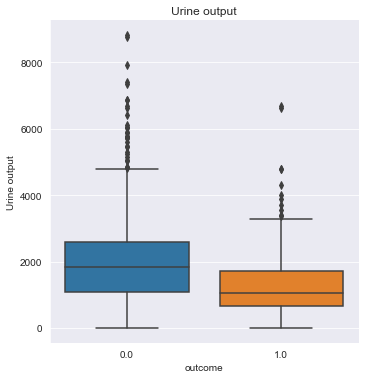

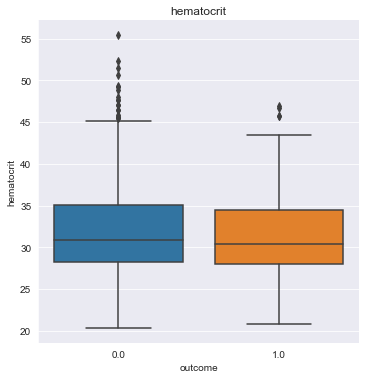

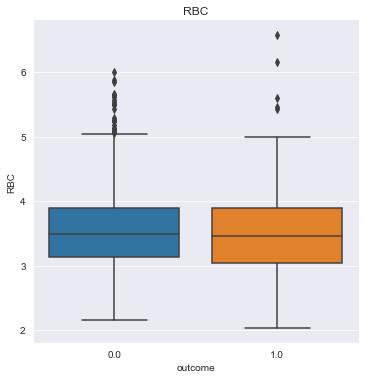

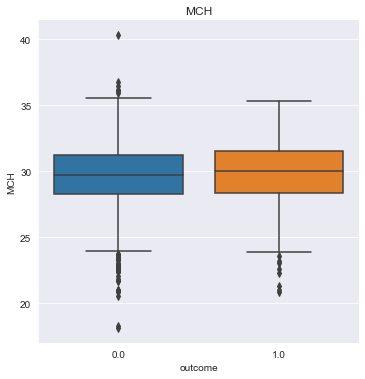

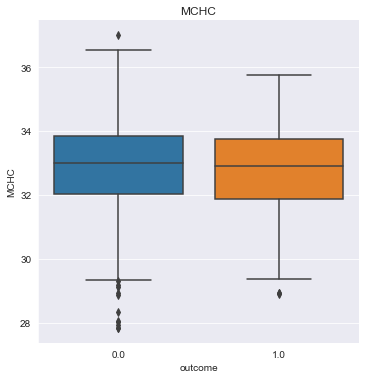

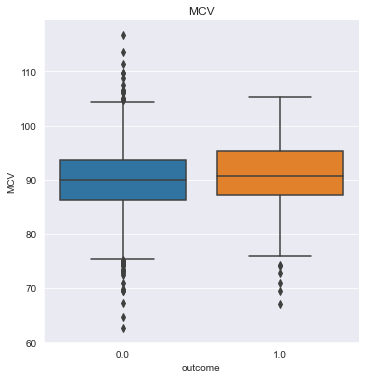

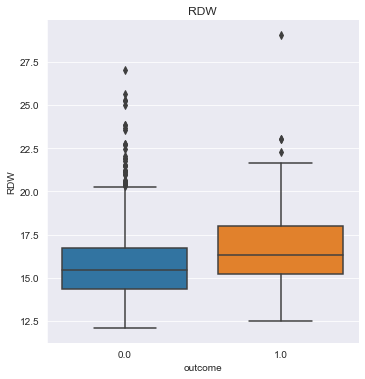

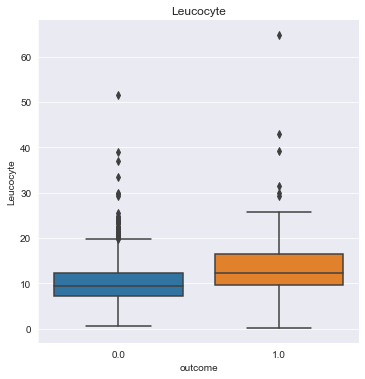

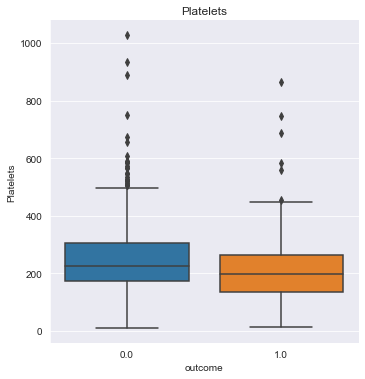

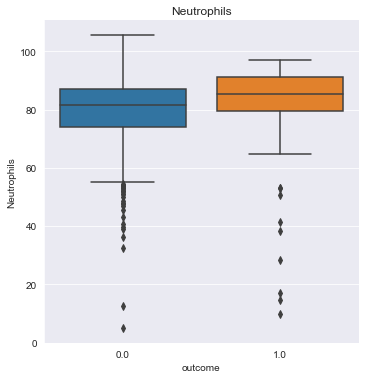

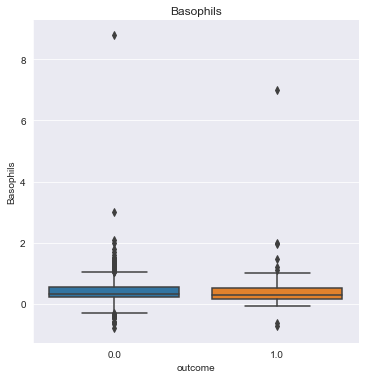

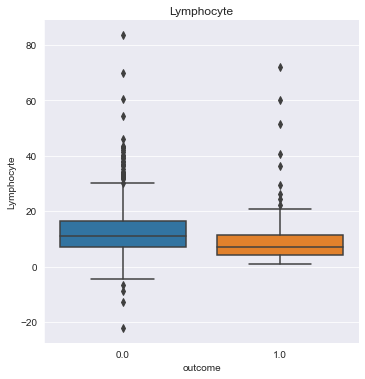

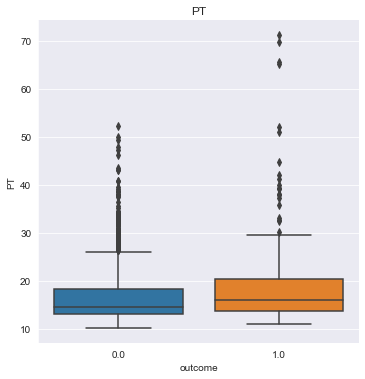

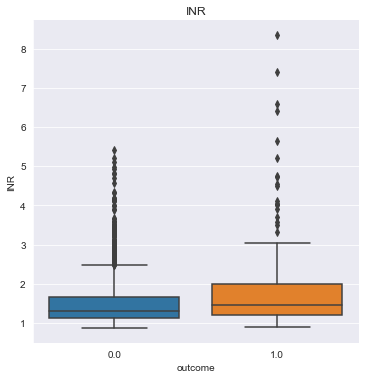

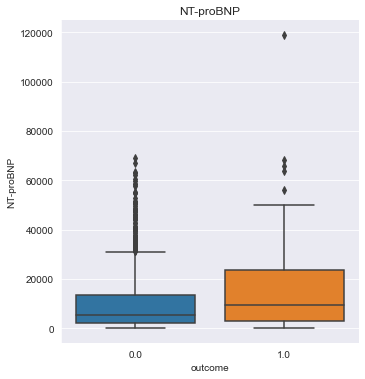

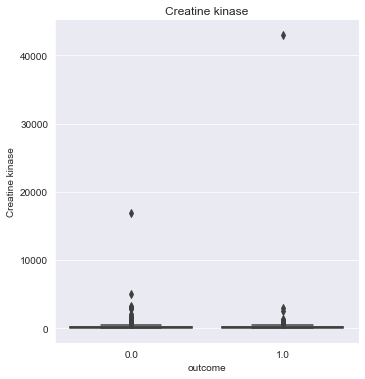

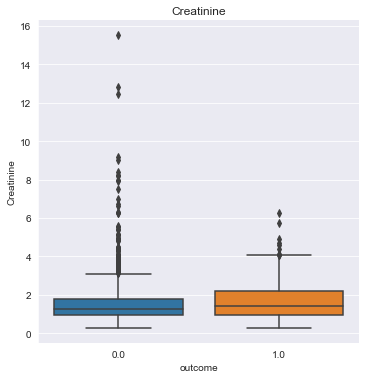

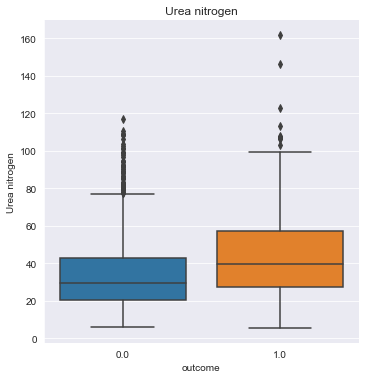

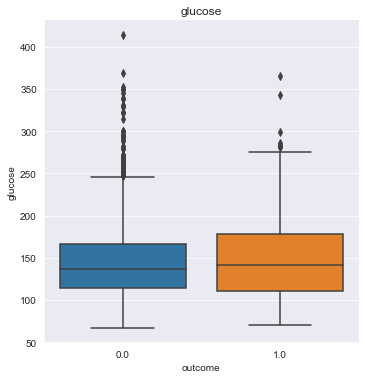

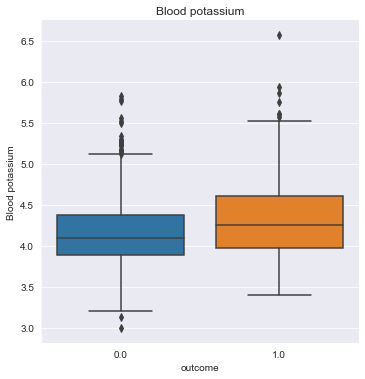

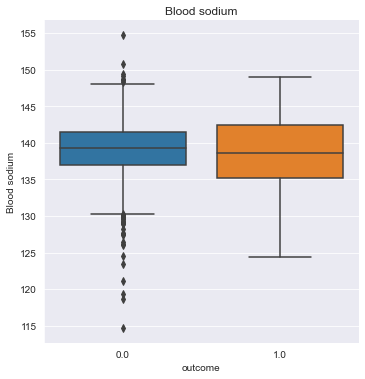

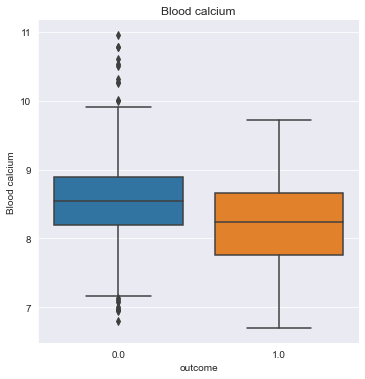

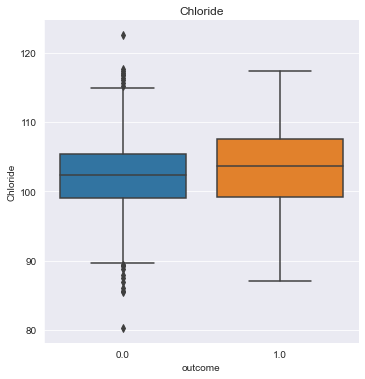

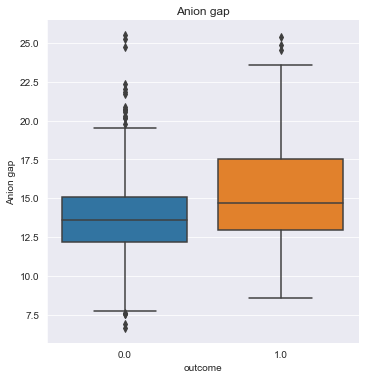

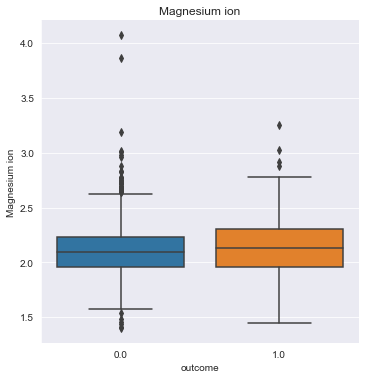

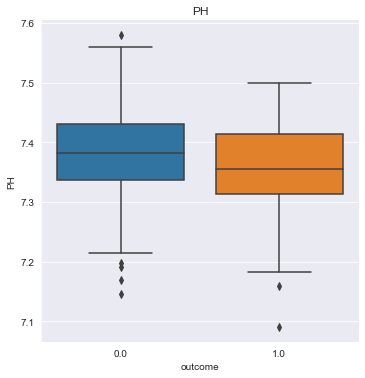

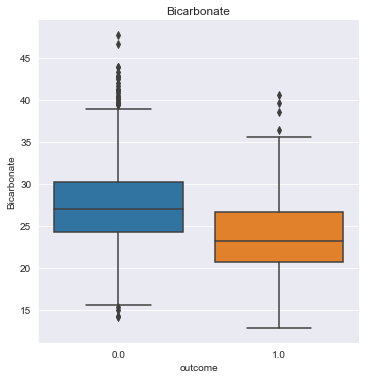

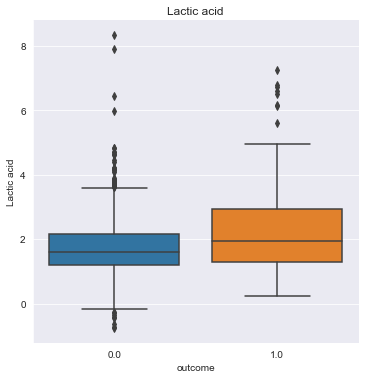

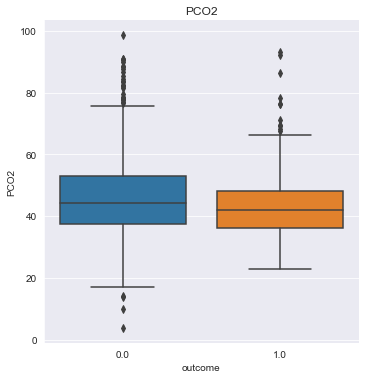

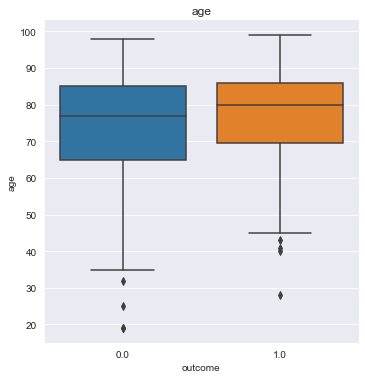

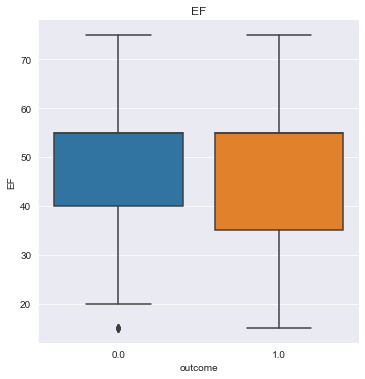

In [108]:
#Box plot for continuous variables  
ListOfContinuousVariables = df[['age','BMI','heart rate','Systolic blood pressure','Diastolic blood pressure','Respiratory rate','temperature','SP O2','Urine output','hematocrit','RBC','MCH','MCHC','MCV','RDW','Leucocyte','Platelets','Neutrophils','Basophils','Lymphocyte','PT','INR','NT-proBNP','Creatine kinase','Creatinine','Urea nitrogen','glucose','Blood potassium','Blood sodium','Blood calcium','Chloride','Anion gap','Magnesium ion','PH','Bicarbonate','Lactic acid','PCO2','age','EF']]

for item in ListOfContinuousVariables:
    sns.catplot(x="outcome", y = df[item], kind= "box", data = df)    
    plt.title(item)
    plt.show()
    

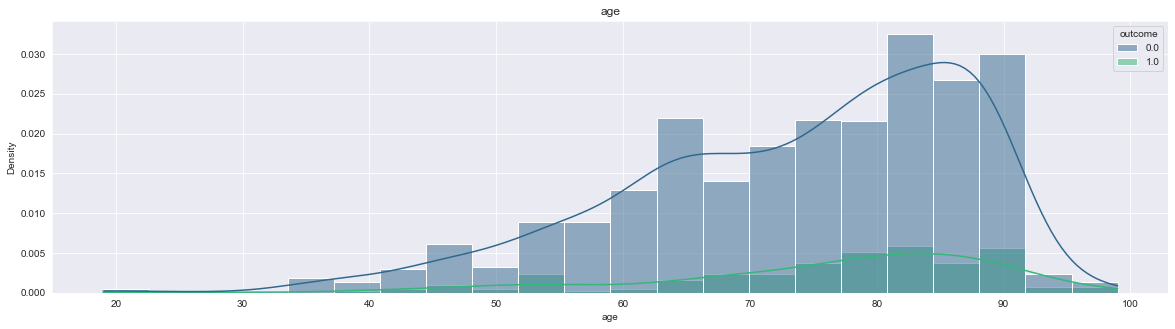

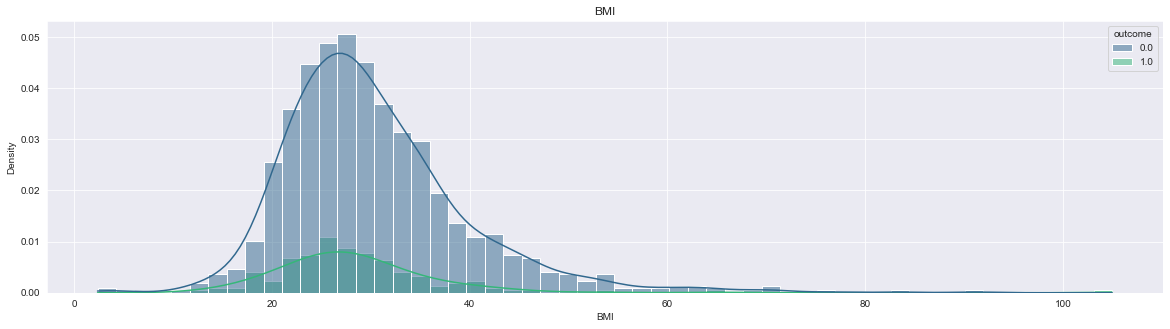

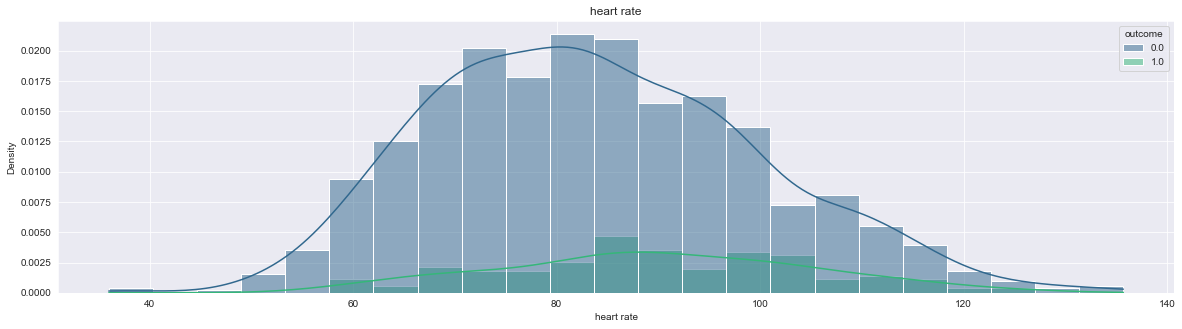

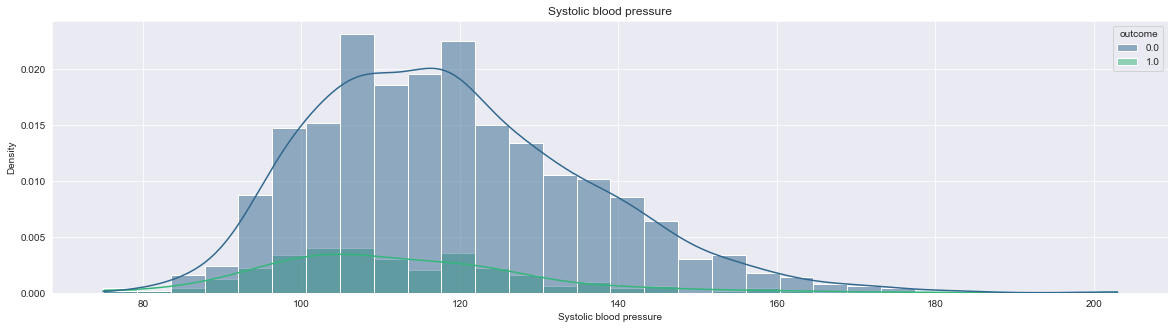

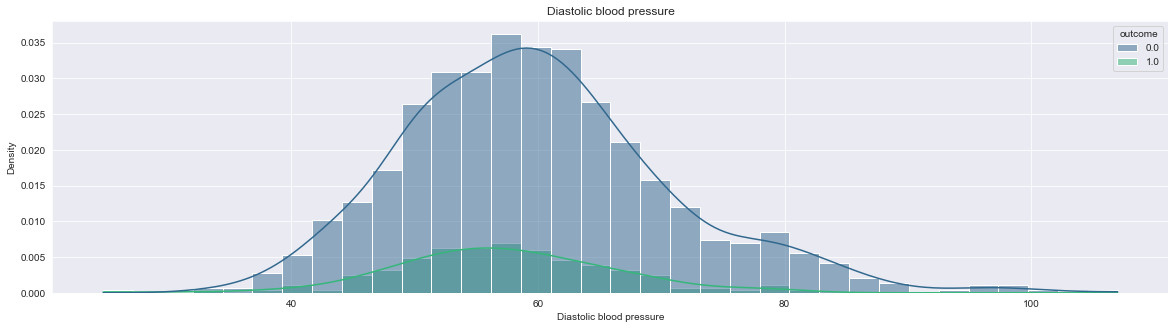

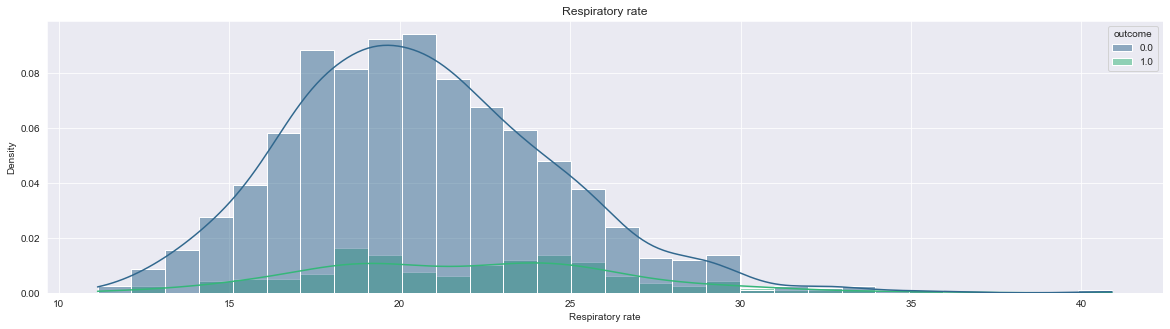

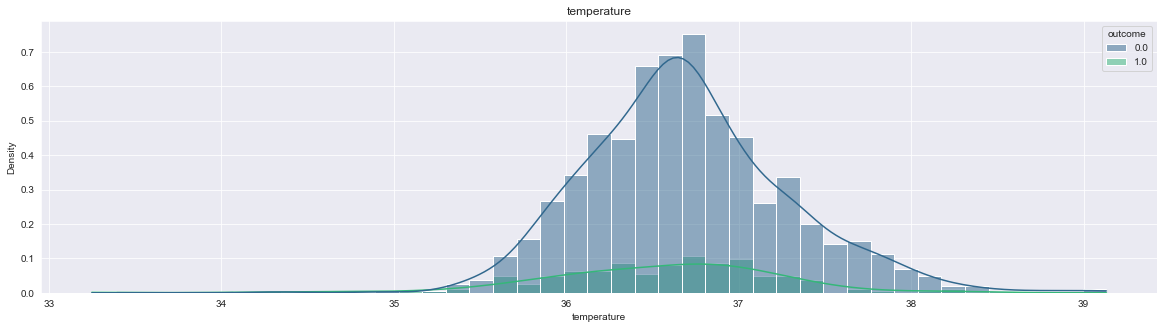

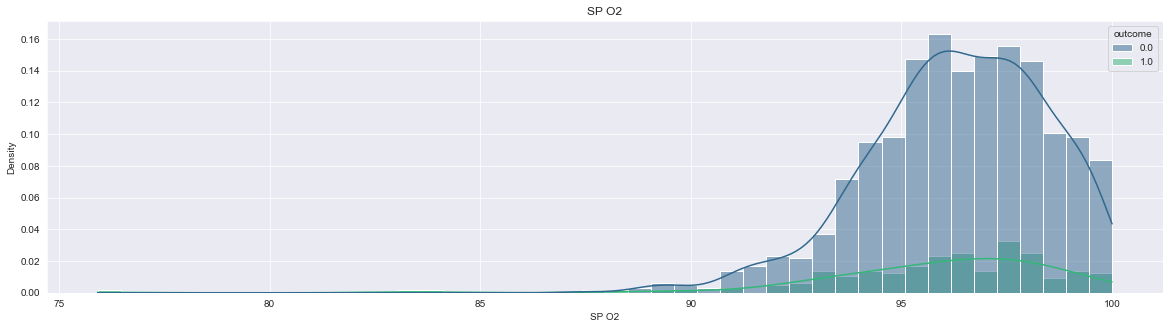

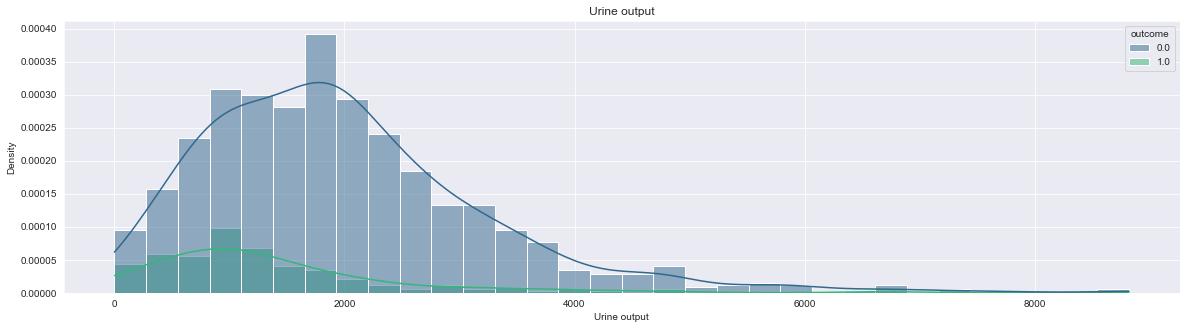

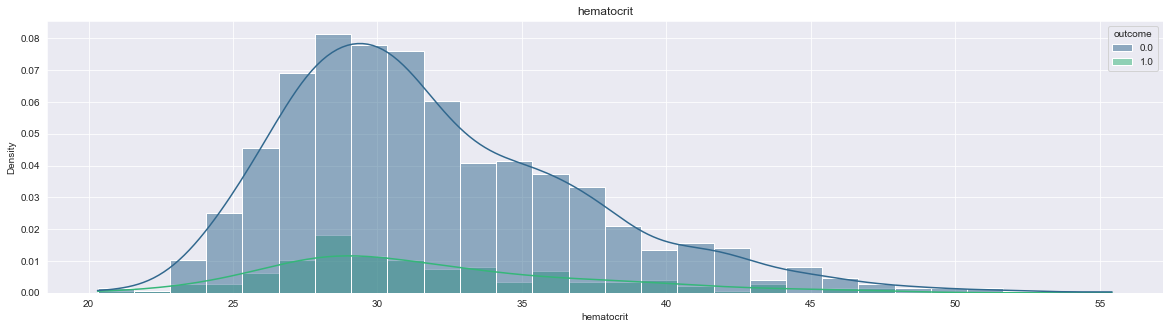

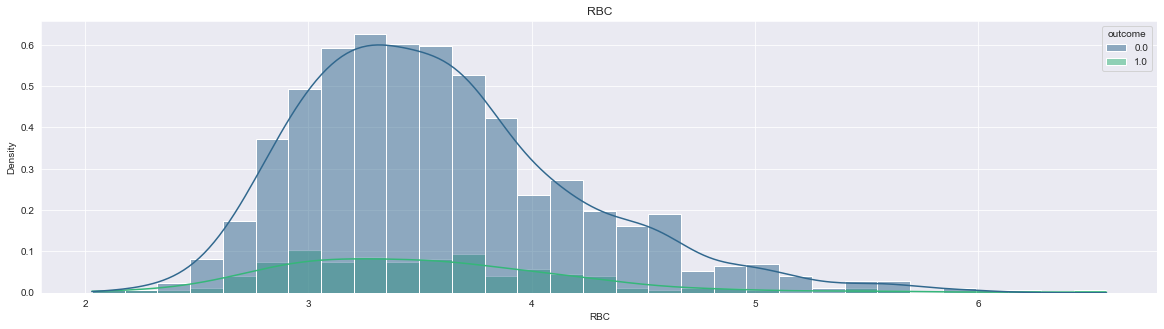

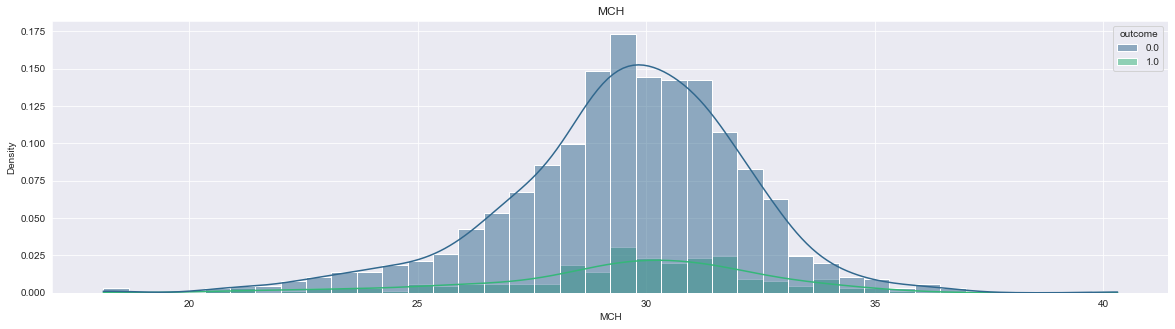

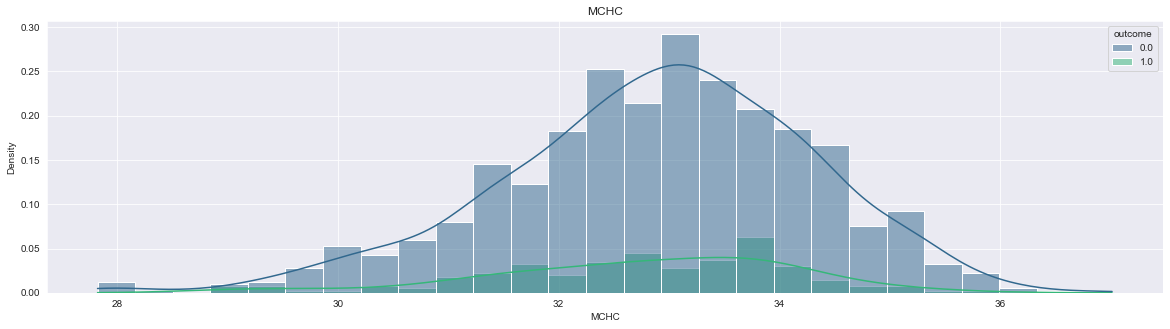

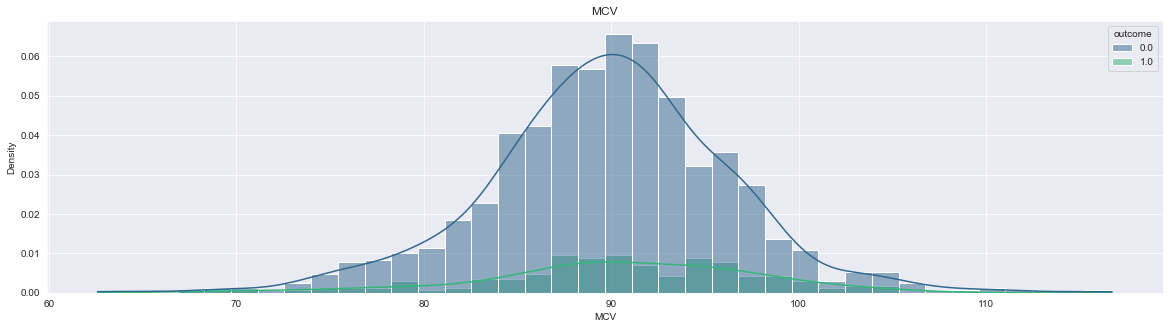

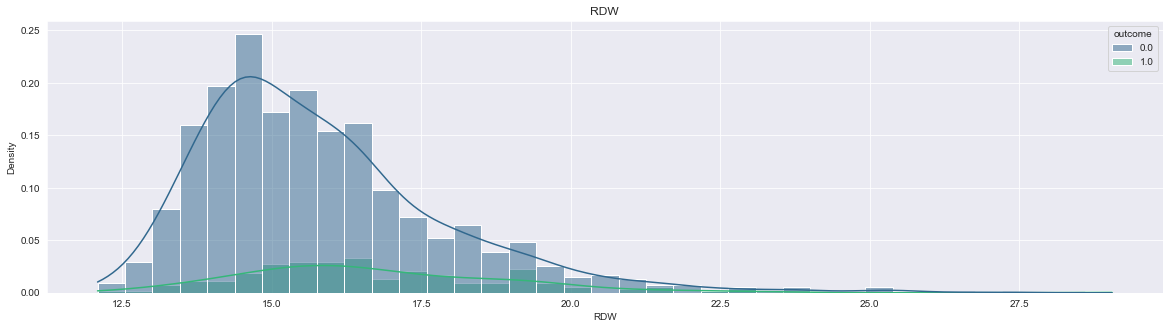

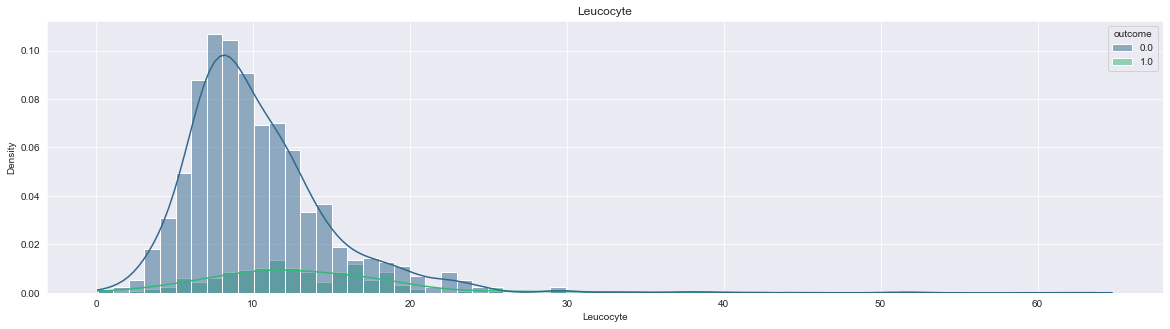

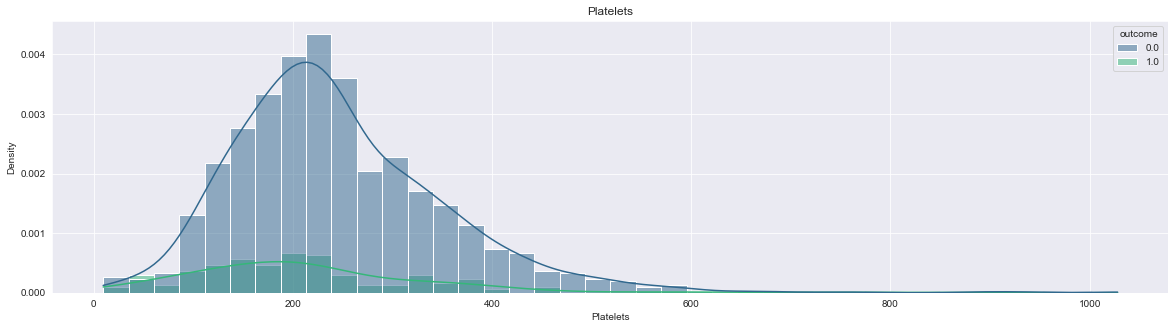

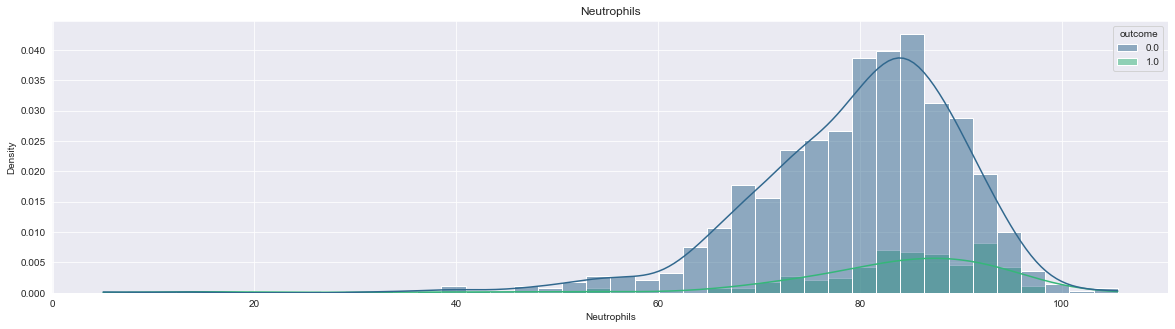

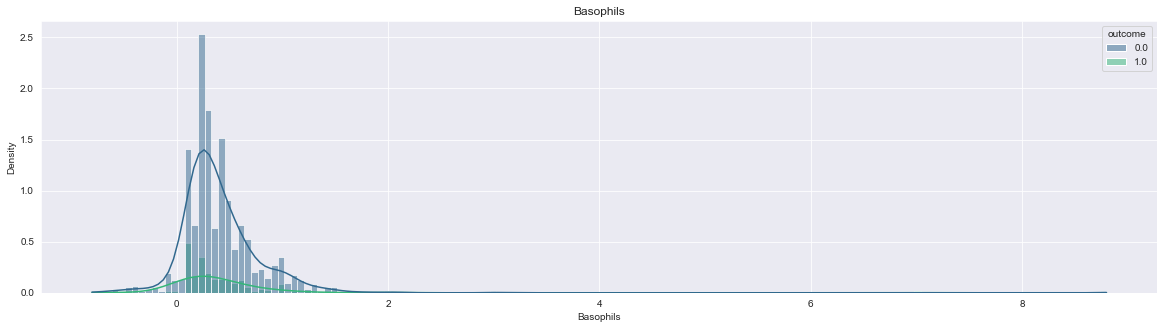

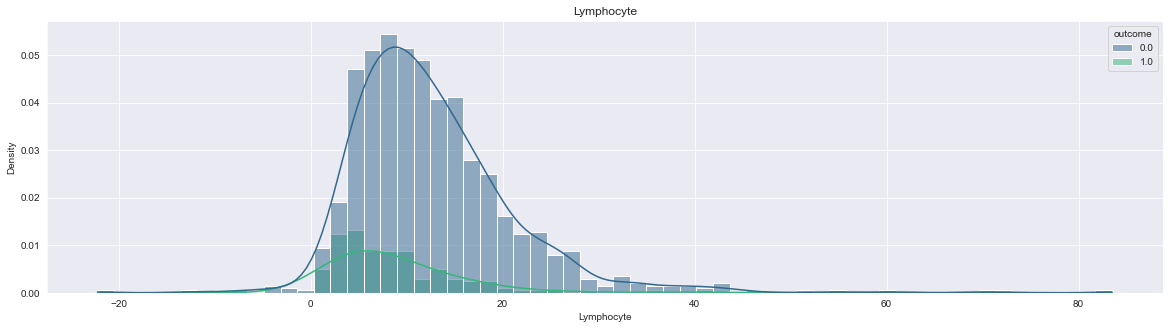

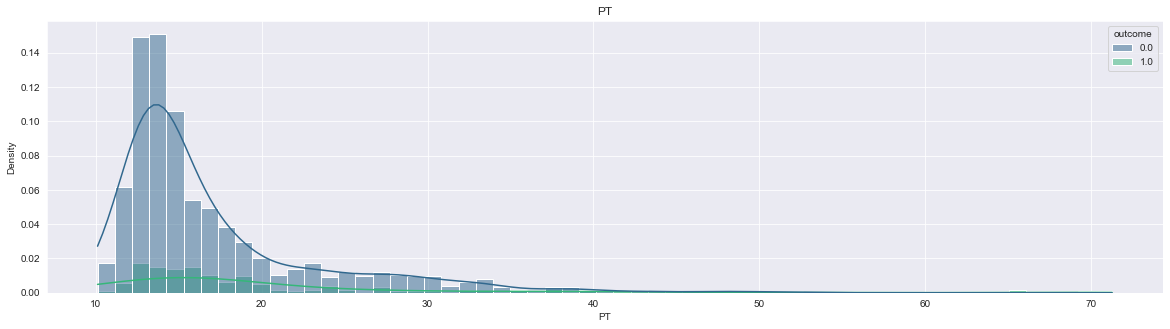

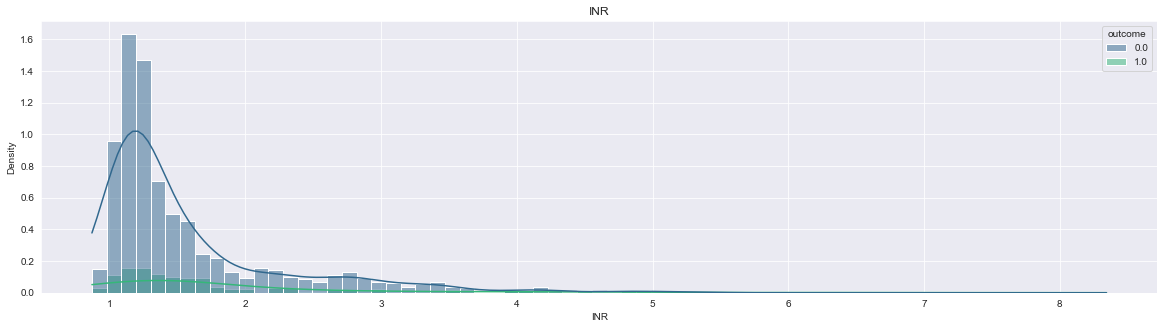

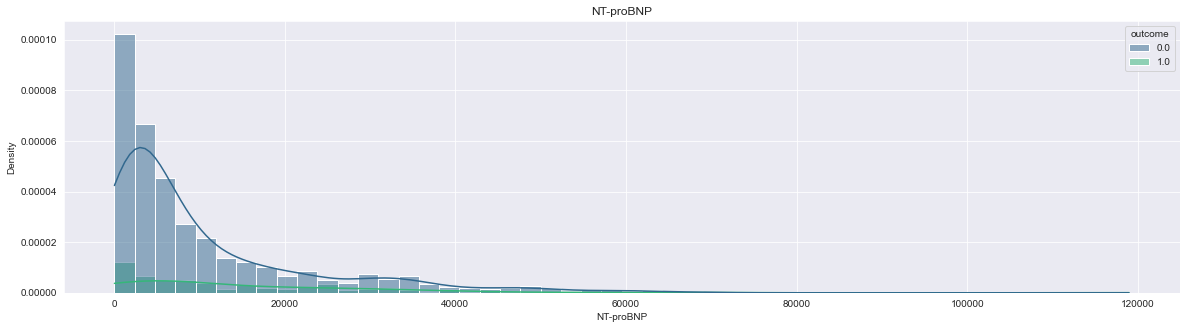

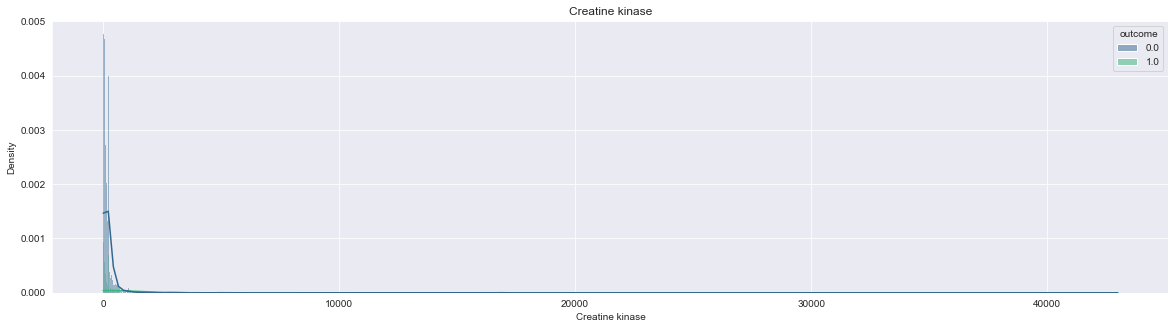

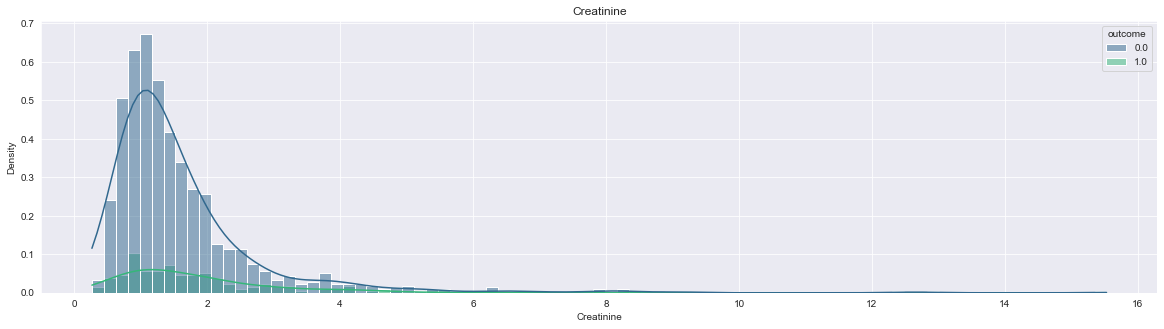

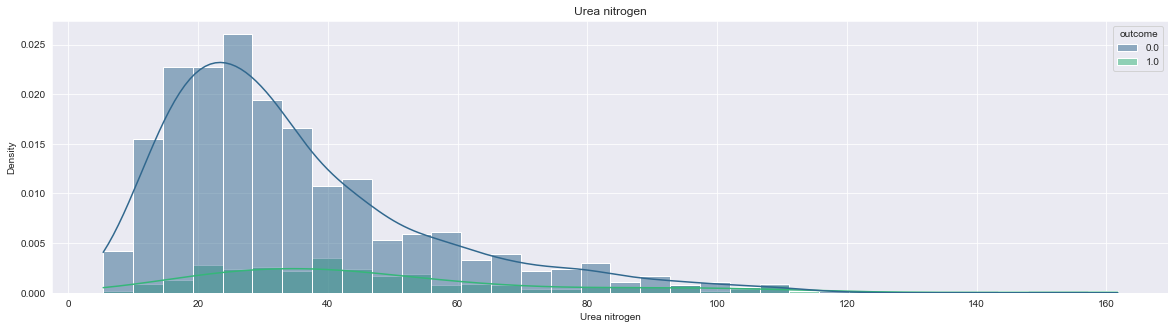

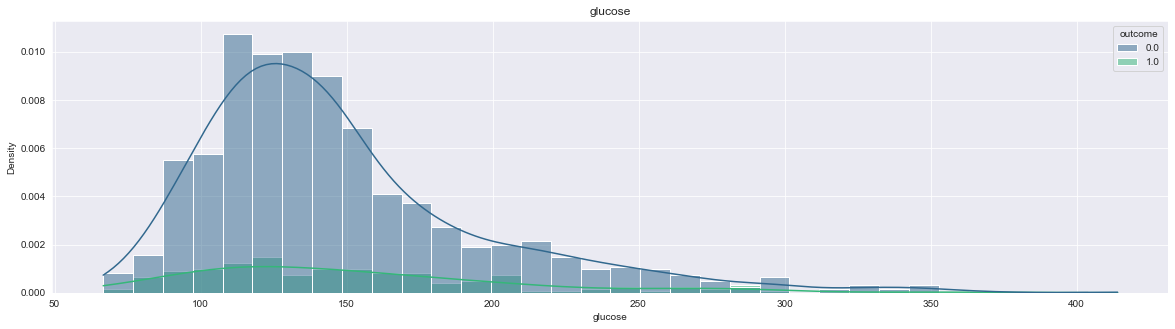

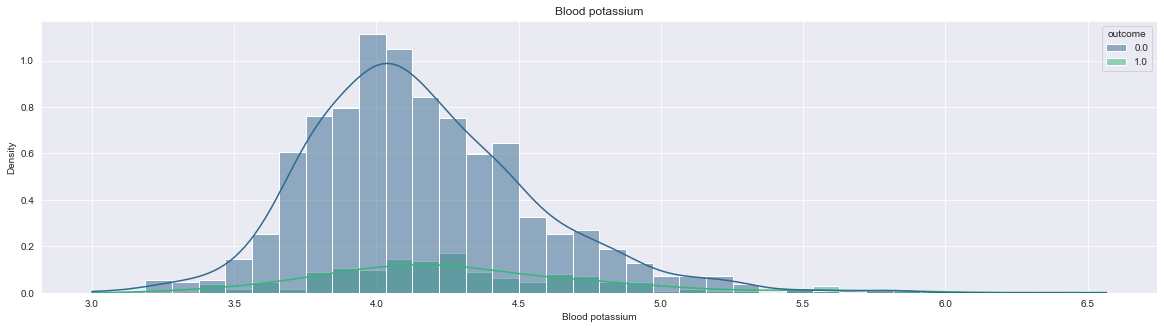

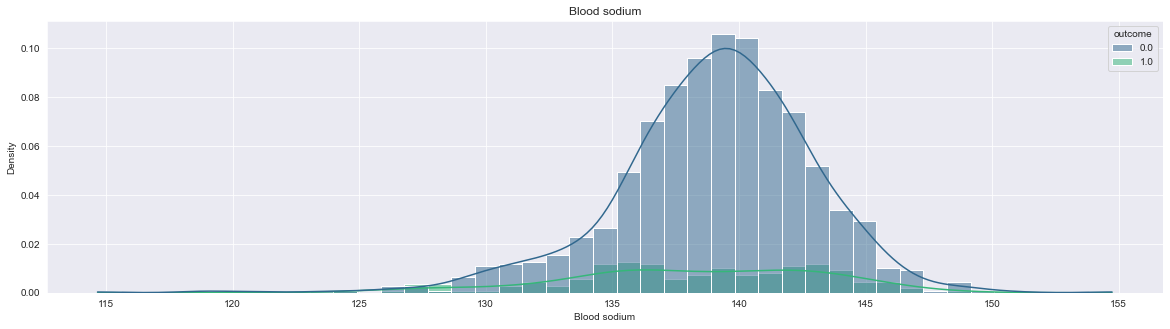

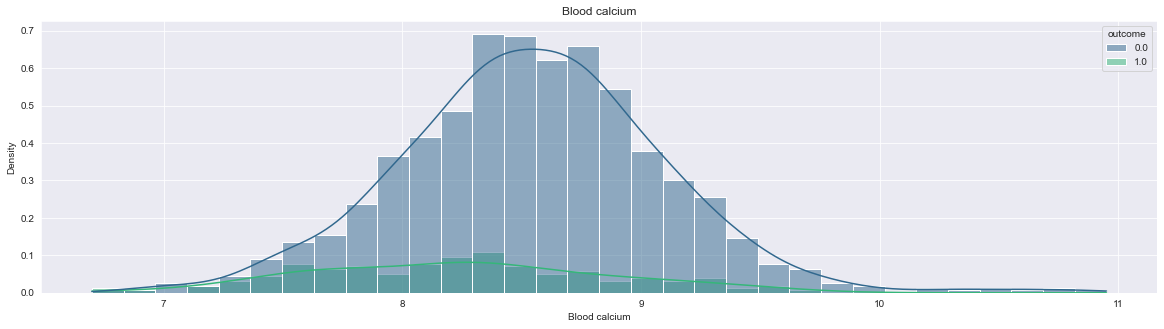

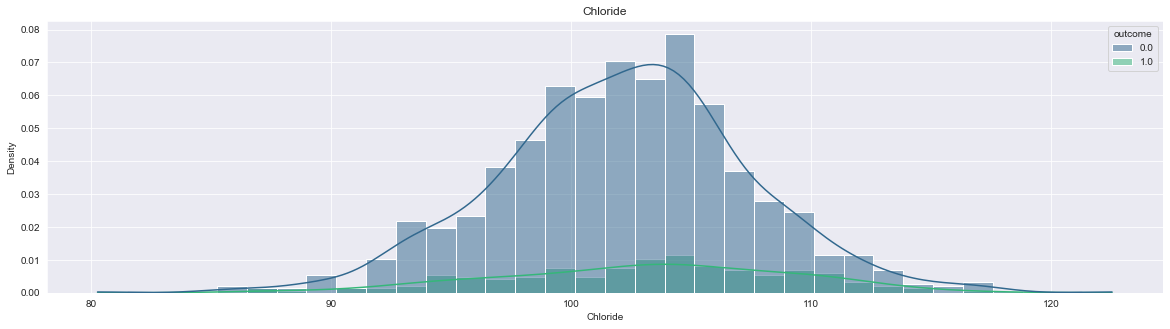

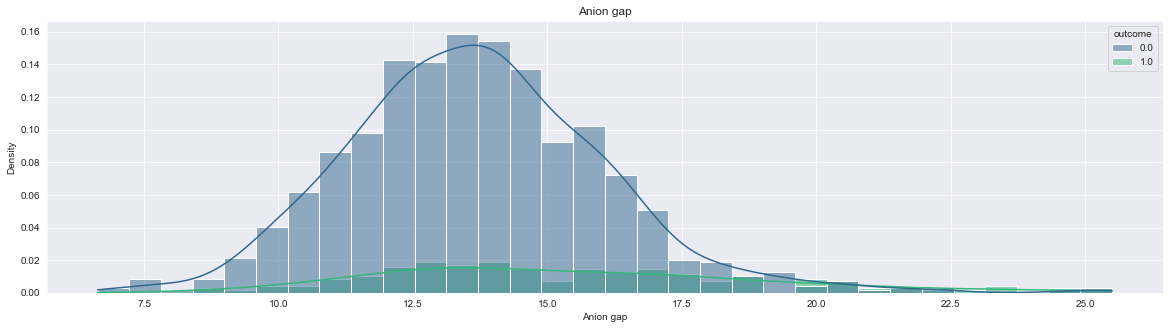

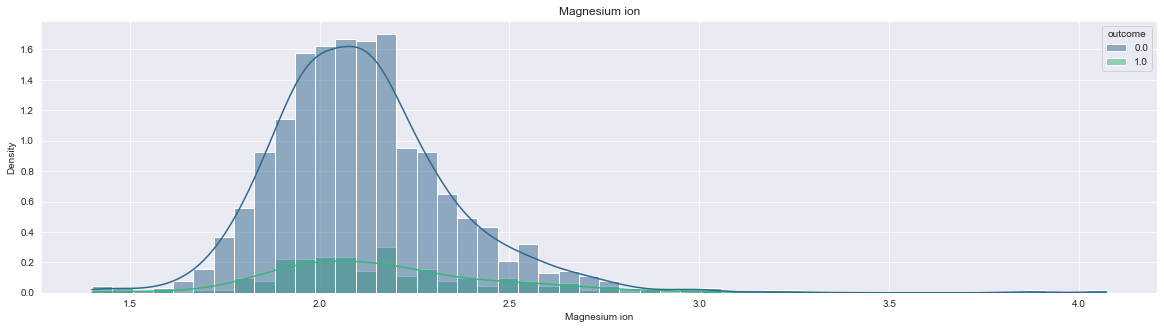

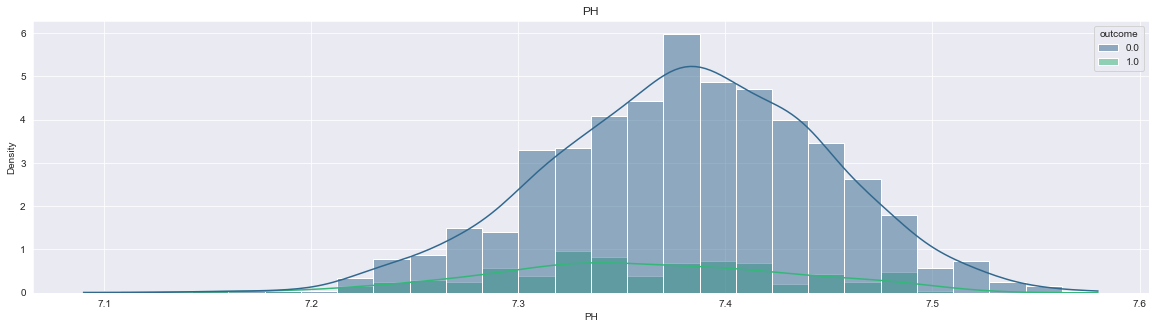

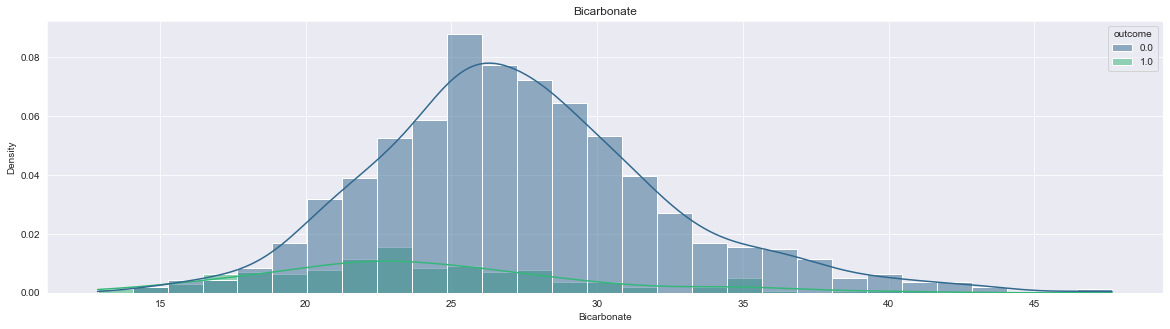

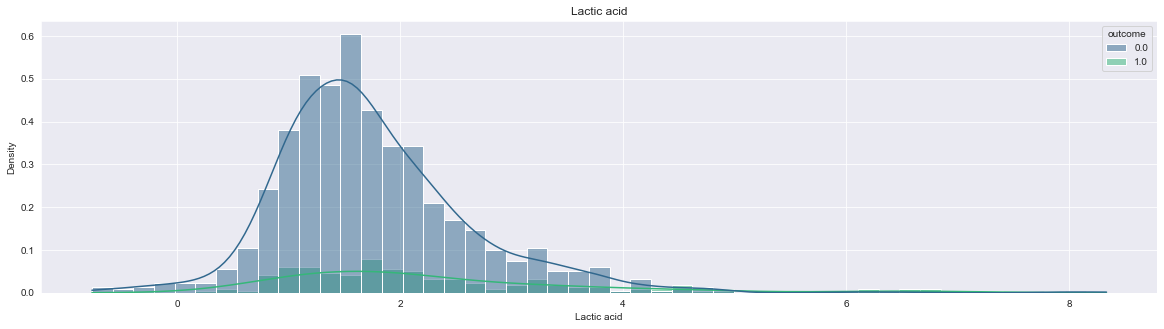

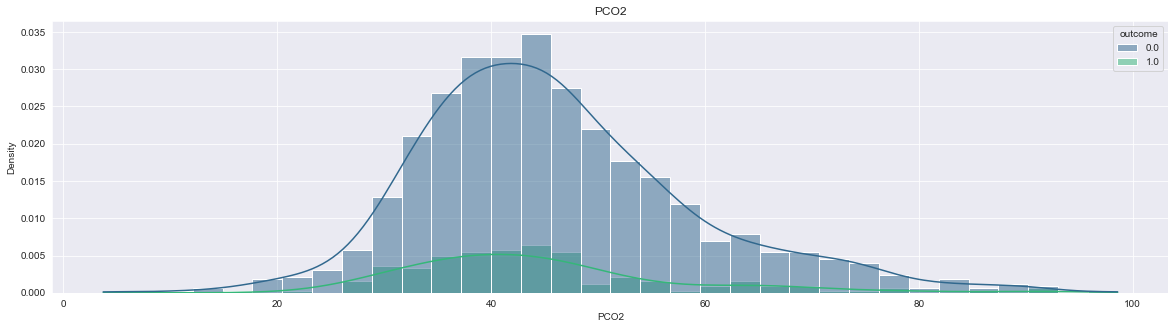

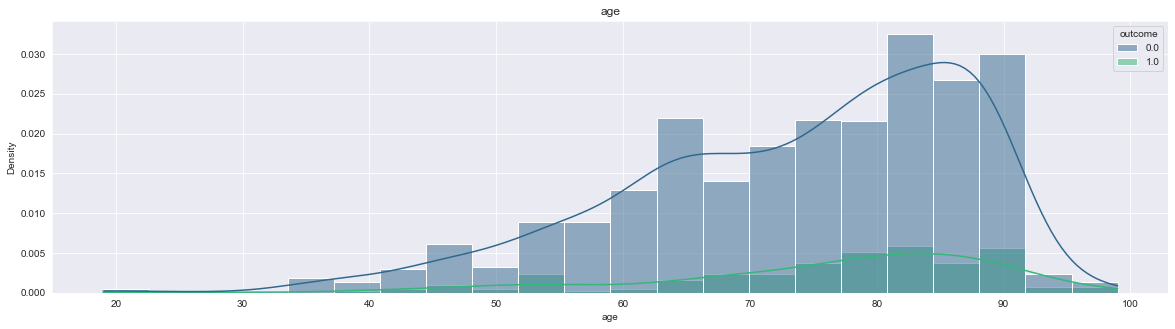

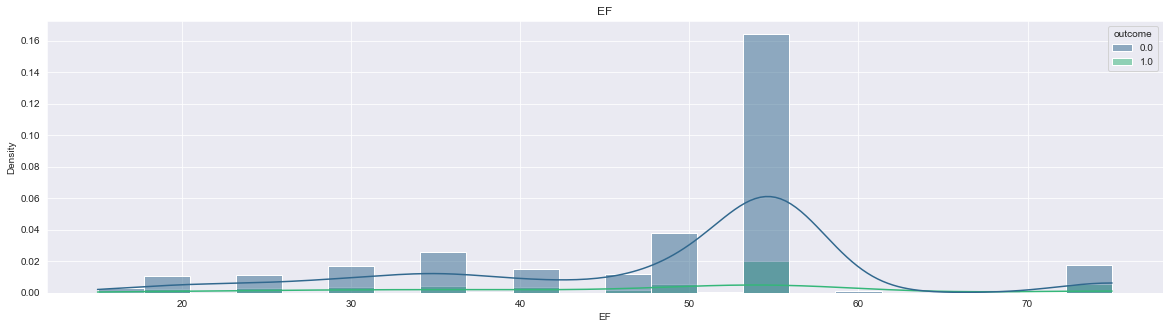

In [109]:
#Continuous Variable Plot
ListOfContinuousVariables = df[['age','BMI','heart rate','Systolic blood pressure','Diastolic blood pressure','Respiratory rate','temperature','SP O2','Urine output','hematocrit','RBC','MCH','MCHC','MCV','RDW','Leucocyte','Platelets','Neutrophils','Basophils','Lymphocyte','PT','INR','NT-proBNP','Creatine kinase','Creatinine','Urea nitrogen','glucose','Blood potassium','Blood sodium','Blood calcium','Chloride','Anion gap','Magnesium ion','PH','Bicarbonate','Lactic acid','PCO2','age','EF']]

for item in ListOfContinuousVariables:
    sns.histplot(data = df, x = item, hue = "outcome", palette="viridis", kde=True, stat="density")
    plt.title(item)
    plt.show()
    
    

### Categorical Variable Plot

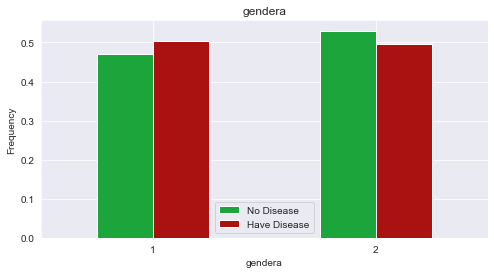

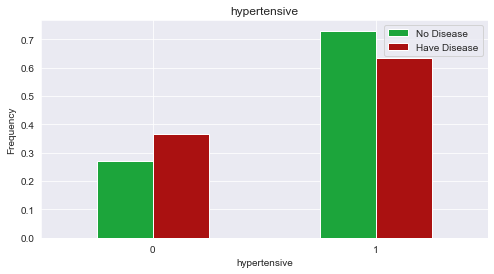

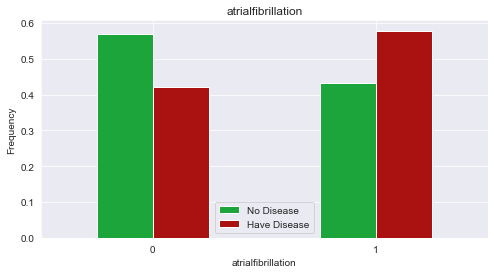

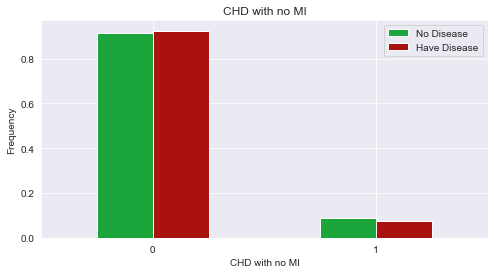

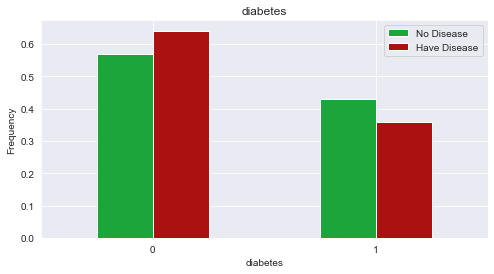

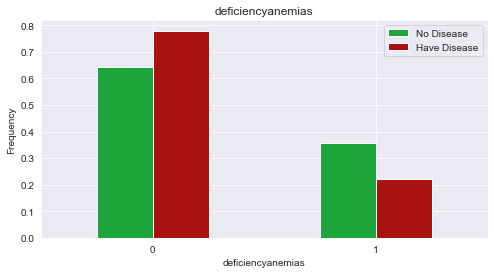

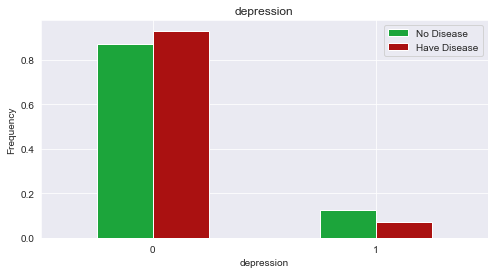

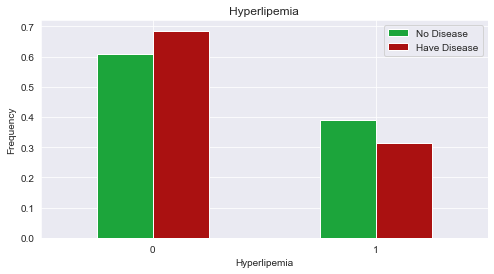

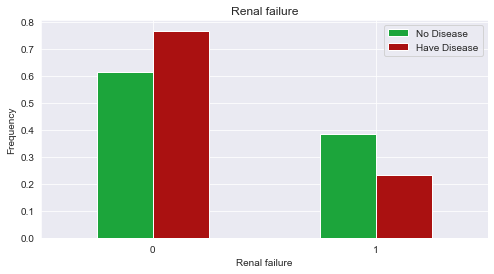

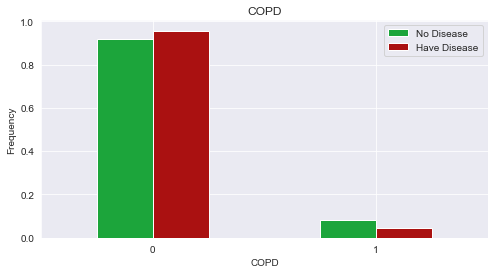

In [110]:
#Categorical Variable Plot
ListOfCategoricalVariables = df[['gendera','hypertensive','atrialfibrillation','CHD with no MI','diabetes','deficiencyanemias','depression','Hyperlipemia','Renal failure','COPD']]

for item in ListOfCategoricalVariables:
    pd.crosstab(df[item],df.outcome, normalize = 'columns').plot(kind="bar",figsize=(8,4),color=['#1CA53B','#AA1111' ])
    plt.title(item)
    plt.xlabel(item)
    plt.xticks(rotation=0)
    plt.legend(["No Disease", "Have Disease"])
    plt.ylabel('Frequency')
    plt.show()

# Initial Linear Regression

In [111]:
#Initial Linear Regression using all variables 
dependent_variable = df['outcome']
independent_variables = df[['age', 'gendera', 'BMI', 'hypertensive',
       'atrialfibrillation', 'CHD with no MI', 'diabetes', 'deficiencyanemias',
       'depression', 'Hyperlipemia', 'Renal failure', 'COPD', 'heart rate',
       'Systolic blood pressure', 'Diastolic blood pressure',
       'Respiratory rate', 'temperature', 'SP O2', 'Urine output',
       'hematocrit', 'RBC', 'MCH', 'MCHC', 'MCV', 'RDW', 'Leucocyte',
       'Platelets', 'Neutrophils', 'Basophils', 'Lymphocyte', 'PT', 'INR',
       'NT-proBNP', 'Creatine kinase', 'Creatinine', 'Urea nitrogen',
       'glucose', 'Blood potassium', 'Blood sodium', 'Blood calcium',
       'Chloride', 'Anion gap', 'Magnesium ion', 'PH', 'Bicarbonate',
       'Lactic acid', 'PCO2', 'EF']]
independent_variables = sm.add_constant(independent_variables)
regression_model = sm.OLS(dependent_variable,independent_variables).fit() 
print(regression_model.summary())

                            OLS Regression Results                            
Dep. Variable:                outcome   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     7.900
Date:                Wed, 22 Dec 2021   Prob (F-statistic):           2.33e-44
Time:                        23:19:40   Log-Likelihood:                -236.15
No. Observations:                1176   AIC:                             570.3
Df Residuals:                    1127   BIC:                             818.7
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [112]:
df.columns

Index(['outcome', 'age', 'gendera', 'BMI', 'hypertensive',
       'atrialfibrillation', 'CHD with no MI', 'diabetes', 'deficiencyanemias',
       'depression', 'Hyperlipemia', 'Renal failure', 'COPD', 'heart rate',
       'Systolic blood pressure', 'Diastolic blood pressure',
       'Respiratory rate', 'temperature', 'SP O2', 'Urine output',
       'hematocrit', 'RBC', 'MCH', 'MCHC', 'MCV', 'RDW', 'Leucocyte',
       'Platelets', 'Neutrophils', 'Basophils', 'Lymphocyte', 'PT', 'INR',
       'NT-proBNP', 'Creatine kinase', 'Creatinine', 'Urea nitrogen',
       'glucose', 'Blood potassium', 'Blood sodium', 'Blood calcium',
       'Chloride', 'Anion gap', 'Magnesium ion', 'PH', 'Bicarbonate',
       'Lactic acid', 'PCO2', 'EF'],
      dtype='object')

In [113]:
#Compare AUC between linear vs. logistic regression and AUC between using all variables or select variables with p value < 0.2

# Consider two sets of variables
all_variables = ['age', 'gendera', 'BMI', 'hypertensive',
       'atrialfibrillation', 'CHD with no MI', 'diabetes', 'deficiencyanemias',
       'depression', 'Hyperlipemia', 'Renal failure', 'COPD', 'heart rate',
       'Systolic blood pressure', 'Diastolic blood pressure',
       'Respiratory rate', 'temperature', 'SP O2', 'Urine output',
       'hematocrit', 'RBC', 'MCH', 'MCHC', 'MCV', 'RDW', 'Leucocyte',
       'Platelets', 'Neutrophils', 'Basophils', 'Lymphocyte', 'PT', 'INR',
       'NT-proBNP', 'Creatine kinase', 'Creatinine', 'Urea nitrogen',
       'glucose', 'Blood potassium', 'Blood sodium', 'Blood calcium',
       'Chloride', 'Anion gap', 'Magnesium ion', 'PH', 'Bicarbonate',
       'Lactic acid', 'PCO2', 'EF']
sig_variables = ['Renal failure','Urea nitrogen','Blood calcium','Leucocyte','Platelets',
               'heart rate','Creatinine','COPD','deficiencyanemias','Diastolic blood pressure',
               'SP O2','Urine output','Lactic acid','temperature','RDW','PCO2',
               'Systolic blood pressure','Blood potassium','Respiratory rate']
target = ["outcome"]

# Make predictions using linear regression model using all variables 
X = df[all_variables]
Y = df["outcome"]
reg = LinearRegression().fit(X, Y)
linreg_all_auc = reg.score(X, Y)

# Make predictions using linear regression model using variables with pvalue <0.2 
X = df[sig_variables]
Y = df["outcome"]
reg = LinearRegression().fit(X, Y)
linreg_sig_auc = reg.score(X, Y)

# Make predictions using logistic regression model using all variables 
X = df[all_variables]
Y = df["outcome"]
logreg = linear_model.LogisticRegression()
logreg.fit(X, Y)
predictions = logreg.predict_proba(X)[:,1]
all_auc = roc_auc_score(Y, predictions)

# Make predictions using logistic regression model using variables with pvalue <0.2 
X = df[sig_variables]
Y = df["outcome"]
logreg = linear_model.LogisticRegression()
logreg.fit(X, Y)
predictions = logreg.predict_proba(X)[:,1]
sig_auc = roc_auc_score(Y, predictions)

# Print auc_1 and auc_2
print(round(linreg_all_auc,2))
print(round(linreg_sig_auc,2))
print(round(all_auc,2))
print(round(sig_auc,2))

0.25
0.22
0.77
0.78


It appears linear regression is not the idea model but there is some promise for logistic regression model. 

# Determine variables to place in machine learning model

In [114]:
#Use the Forward Stepwise Approach to Identify which Variable is the most to least significant 

# function to calculate AUC
def auc(variables, target, df):
    X = df[variables]
    Y = df[target]
    logreg = linear_model.LogisticRegression()
    logreg.fit(X, Y)
    predictions = logreg.predict_proba(X)[:,1]
    auc = roc_auc_score(Y, predictions)
    return(auc)

def next_best(current_variables,candidate_variables, target, df):
    best_auc = -1
    best_variable = None
    
    # Calculate the auc score of adding v to the current variables
    for v in candidate_variables:
        auc_v = auc(current_variables + [v],target, df)
        
        # Update best_auc and best_variable adding v led to a better auc score
        if auc_v >= best_auc:
            best_auc = auc_v
            best_variable = v
            
    return best_variable
    

In [115]:
candidate_variables = list(df.columns.values)
candidate_variables.remove("outcome")
current_variables = []
target = ["outcome"]
max_number_variables = 48
number_iterations = min(max_number_variables, len(candidate_variables))
for i in range(0, number_iterations):
    next_variable = next_best(current_variables, candidate_variables, target, df)
    current_variables = current_variables + [next_variable]
    candidate_variables.remove(next_variable)
print(current_variables)

['Bicarbonate', 'Urine output', 'Leucocyte', 'Platelets', 'Renal failure', 'Urea nitrogen', 'PCO2', 'Systolic blood pressure', 'atrialfibrillation', 'Basophils', 'hypertensive', 'Magnesium ion', 'deficiencyanemias', 'Blood calcium', 'PH', 'depression', 'COPD', 'PT', 'diabetes', 'Hyperlipemia', 'CHD with no MI', 'heart rate', 'SP O2', 'age', 'RDW', 'BMI', 'Respiratory rate', 'MCV', 'Diastolic blood pressure', 'Creatinine', 'MCH', 'temperature', 'Lactic acid', 'Lymphocyte', 'RBC', 'MCHC', 'Blood potassium', 'glucose', 'Blood sodium', 'EF', 'gendera', 'hematocrit', 'INR', 'Neutrophils', 'Chloride', 'Anion gap', 'Creatine kinase', 'NT-proBNP']


In [116]:
#  Partitioning 
# Create dataframes with variables and target
X = df.drop('outcome', 1)
Y = df["outcome"]

# Carry out 70-30 partititioning with stratification
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, stratify = Y)

# Create the final train and test dfs
train = pd.concat([X_train, Y_train], axis=1)
test = pd.concat([X_test, Y_test], axis=1)

# Check whether train and test have same percentage targets
print(round(sum(train["outcome"])/len(train), 2))
print(round(sum(test["outcome"])/len(test), 2))

0.13
0.14


In [117]:
#Determine the number of variables to use by graphing out AUC of test and train datasets

def auc_train_test(variables, target, train, test):
    X_train = train[variables]
    X_test = test[variables]
    Y_train = train[target]
    Y_test = test[target]
    logreg = linear_model.LogisticRegression()
    
    # Fit the model on train data
    logreg.fit(X_train, Y_train)
    
    # Calculate the predictions both on train and test data
    predictions_train = logreg.predict_proba(X_train)[:,1]
    predictions_test = logreg.predict_proba(X_test)[:,1]
    
    # Calculate the AUC both on train and test data
    auc_train = roc_auc_score(Y_train, predictions_train)
    auc_test = roc_auc_score(Y_test,predictions_test)
    return(auc_train, auc_test)

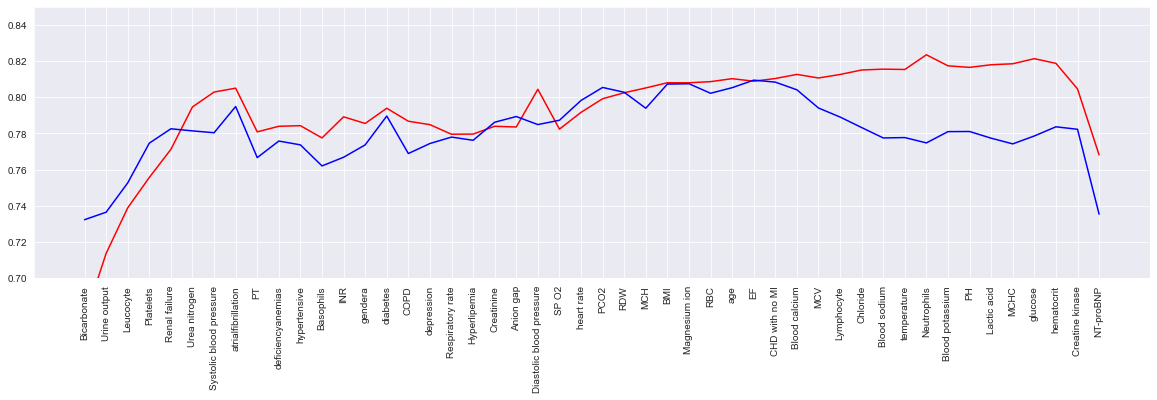

In [126]:
# Variable order resulting from the forward stepwise variable selection procedure
variables_forward = ['Bicarbonate', 'Urine output', 'Leucocyte', 'Platelets', 'Renal failure', 'Urea nitrogen', 
                     'Systolic blood pressure', 'atrialfibrillation', 'PT', 'deficiencyanemias', 'hypertensive', 
                     'Basophils', 'INR', 'gendera', 'diabetes', 'COPD', 'depression', 'Respiratory rate', 
                     'Hyperlipemia', 'Creatinine', 'Anion gap', 'Diastolic blood pressure', 'SP O2', 
                     'heart rate', 'PCO2', 'RDW', 'MCH', 'BMI', 'Magnesium ion', 'RBC', 'age', 'EF', 
                     'CHD with no MI', 'Blood calcium', 'MCV', 'Lymphocyte', 'Chloride', 'Blood sodium', 
                     'temperature', 'Neutrophils', 'Blood potassium', 'PH', 'Lactic acid', 'MCHC', 'glucose', 
                     'hematocrit', 'Creatine kinase', 'NT-proBNP']

# Keep track of train and test AUC values
auc_values_train = []
auc_values_test = []

# Add variables one by one
variables_evaluate = []

# Iterate over the variables in variables
for v in variables_forward:
  
    # Add the variable
    variables_evaluate.append(v)
    
    # Calculate the train and test AUC of this set of variables
    auc_train, auc_test = auc_train_test(variables_evaluate, ["outcome"], train,test)
    
    # Append the values to the lists
    auc_values_train.append(auc_train)
    auc_values_test.append(auc_test)
    
# Make plot of the AUC values
x = np.array(range(0,len(auc_values_train)))
y_train = np.array(auc_values_train)
y_test = np.array(auc_values_test)
plt.xticks(x, variables_forward, rotation = 90)
plt.plot(x,y_train, color = 'red', label = "train")
plt.plot(x,y_test, color = 'blue', label = "test")
plt.ylim((0.7, 0.85))
plt.show()

As more variables are added, the training dataset will rise in AUC but the test dataset AUC will fall or have diminishing returns due to overfitting. As seen above, diminishing AUC is seen in the test (blue) data set at “CHD with MI” variable. Our new model will include all variables before “CHD with MI”. 

# Building & Comparing Predictive Models

In [131]:
# Predictive variables
variables = ['Bicarbonate', 'Urine output', 'Leucocyte', 'Platelets', 'Renal failure', 'Urea nitrogen', 
                     'Systolic blood pressure', 'atrialfibrillation', 'PT', 'deficiencyanemias', 'hypertensive', 
                     'Basophils', 'INR', 'gendera', 'diabetes', 'COPD', 'depression', 'Respiratory rate', 
                     'Hyperlipemia', 'Creatinine', 'Anion gap', 'Diastolic blood pressure', 'SP O2', 
                     'heart rate', 'PCO2', 'RDW', 'MCH', 'BMI', 'Magnesium ion', 'RBC', 'age', 'EF']
# Select predictors and target
X = df[variables]
y = df[["outcome"]]

# Split the dataset into 70% train, 30% test
X_train, X_test, y_train, y_test= train_test_split(X, y,test_size=0.3,stratify=y,random_state=SEED)

## Ensemble Approach

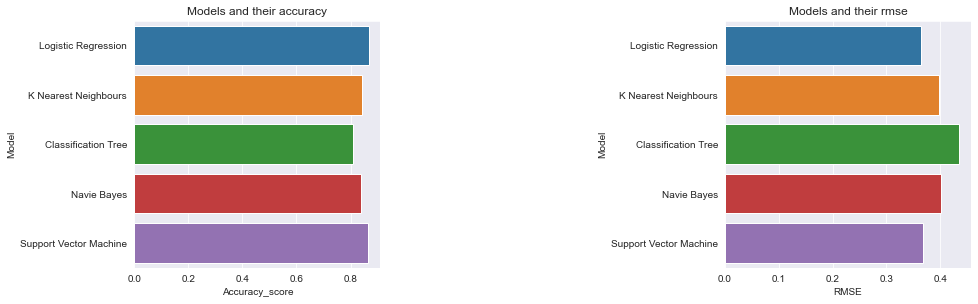

In [132]:
lr = LogisticRegression(random_state=SEED)
kn = KNN(n_neighbors=9, leaf_size=20)
dt = DecisionTreeClassifier(random_state=SEED)
nb = GaussianNB()
SVC = svm.SVC(kernel='rbf', random_state = 42)

lr.fit(X_train, y_train)
kn.fit(X_train, y_train)
dt.fit(X_train, y_train)
nb.fit(X_train, y_train)
SVC.fit(X_train, y_train)

lr_2 = accuracy_score(y_test, lr.predict(X_test))
kn_2 = accuracy_score(y_test, kn.predict(X_test))
dt_2 = accuracy_score(y_test, dt.predict(X_test))
nb_2 = accuracy_score(y_test, nb.predict(X_test))
SVC_2 = accuracy_score(y_test, SVC.predict(X_test))  

lr_rmse = mean_squared_error(y_test, lr.predict(X_test), squared=False)
kn_rmse = mean_squared_error(y_test, kn.predict(X_test), squared=False)
dt_rmse = mean_squared_error(y_test, dt.predict(X_test), squared=False)
nb_rmse = mean_squared_error(y_test, nb.predict(X_test), squared=False)
SVC_rmse = mean_squared_error(y_test, SVC.predict(X_test), squared=False)

#Accuracy score dataframe
models = pd.DataFrame({
    'Model':['Logistic Regression', 'K Nearest Neighbours', 'Classification Tree', 'Navie Bayes','Support Vector Machine'],
    'Accuracy_score':[lr_2, kn_2, dt_2, nb_2, SVC_2],
    'RMSE':[lr_rmse, kn_rmse, dt_rmse,  nb_rmse, SVC_rmse]
})
models

plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
sns.barplot(x='Accuracy_score', y='Model', data=models)
plt.title("Models and their accuracy")

plt.subplot(2,3,3)
sns.barplot(x='RMSE', y='Model', data=models)
plt.title("Models and their rmse")

plt.show()

In [133]:
models.sort_values(by='RMSE', ascending=False)
models.sort_values(by='Accuracy_score', ascending=False)

Model  Accuracy_score      RMSE
0     Logistic Regression        0.866856  0.364890
4  Support Vector Machine        0.864023  0.368751
1    K Nearest Neighbours        0.841360  0.398297
3             Navie Bayes        0.838527  0.401837
2     Classification Tree        0.810198  0.435662

# Interactive Risk Calculator

In [139]:
###Using the model in real time 

#standardze the data 
sc=StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#Choose the model with the highest AUC 
lr = LogisticRegression(random_state=SEED)
lr.fit(X_train, y_train)

#Users to plug in value 

test=pd.DataFrame()
###Demographics
test['age'] = [input("Age (yrs):						")]	
test['gendera'] = [input("Gender (1 for Male, 2 for Female):			")]				
test['BMI'] = [input("BMI:							")]	

###Past Medical History
test['hypertensive'] = [input("Hypertensive (0 for No, 1 for Yes):			")]
test['atrialfibrillation'] = [input("Atrial Fibrillation (0 for No, 1 for Yes):		")]		
test['diabetes'] = [input("Diabetes (0 for No, 1 for Yes):				")]			
test['deficiencyanemias'] = [input("Deficiency Anemias (0 for No, 1 for Yes):		")]				
test['depression'] = [input("Depression (0 for No, 1 for Yes):			")]				
test['Hyperlipemia'] = [input("Hyperlipemia (0 for No, 1 for Yes):			")]			
test['Renal failure'] = [input("Renal failure (0 for No, 1 for Yes):			")]	
test['COPD'] = [input("COPD (0 for No, 1 for Yes):				")]			

###Vitals
test['heart rate'] = [input("Heart rate:						")]	
test['Systolic blood pressure'] = [input("Systolic blood pressure:				")]			
test['Diastolic blood pressure'] = [input("Diastolic blood pressure:				")]			
test['Respiratory rate'] = [input("Respiratory rate:					")]		
test['SP O2'] = [input("SpO2:							")]			
test['Urine output'] = [input("Urine output (first 24 hours mL):			")]			

###CBC
test['RBC'] = [input("RBC:							")]
test['MCH'] = [input("MCH:							")]
test['RDW'] = [input("RDW:							")]
test['Leucocyte'] = [input("Leucocyte:						")]	
test['Platelets'] = [input("Platelets:						")]	
test['Basophils'] = [input("Basophils:						")]	
test['PT'] = [input("PT:							")]
test['INR'] = [input("INR:							")]

###Renal Function
test['Creatinine'] = [input("Serum Creatinine:					")]	
test['Urea nitrogen'] = [input("BUN:							")]		

###Chemistry and Acid Base
test['Anion gap'] = [input("Anion gap:						")]	
test['Magnesium ion'] = [input("Magnesium ion:						")]		
test['Bicarbonate'] = [input("Bicarbonate:						")]	
test['PCO2'] = [input("pCO2:							")]	

test['EF'] = [input("Ejection Fraction:					")]				


test1 = sc.transform(test)
y = lr.predict(test1)
if y == [0]:
    print('Patient is not at high risk for mortality')
else :
    print('Patient is at high risk for mortality')

Age (yrs):						83
Gender (1 for Male, 2 for Female):			2
BMI:							52.9
Hypertensive (0 for No, 1 for Yes):			1
Atrial Fibrillation (0 for No, 1 for Yes):		0
Diabetes (0 for No, 1 for Yes):				0
Deficiency Anemias (0 for No, 1 for Yes):		1
Depression (0 for No, 1 for Yes):			0
Hyperlipemia (0 for No, 1 for Yes):			0
Renal failure (0 for No, 1 for Yes):			1
COPD (0 for No, 1 for Yes):				0
Heart rate:						83.69
Systolic blood pressure:				157.2
Diastolic blood pressure:				58.2
Respiratory rate:					15.6
SpO2:							99.8
Urine output (first 24 hours mL):			1495
RBC:							2.64
MCH:							29.8
RDW:							15.4
Leucocyte:						10.7
Platelets:						304.4
Basophils:						0.1
PT:							12.55
INR:							1.075
Serum Creatinine:					2.05
BUN:							54.7
Anion gap:						14.5
Magnesium ion:						2.055
Bicarbonate:						28.8
pCO2:							54.9
Ejection Fraction:					30
Patient is not at high risk for mortality


As you can probably realize, 32 variables are a lot of variables to enter for a risk calculator. Instead of using the forward stepwise approach - what would the accuracy of the prediction model look like if we are only choosing what a clinical believes to be relevant factors?

# Clinician Picks the Variables vs. Stepwise Approach

For fun, I decided to pick 15 variables that I thought were significant to mortality (a clinician’s best guess) and compare the AUC generated vs. using the stepwise approach. Here are the results: 

In [148]:
# Predictive variables
variables = ['age','gendera','BMI','atrialfibrillation','CHD with no MI','diabetes','COPD',
             'heart rate','Systolic blood pressure','Diastolic blood pressure','Respiratory rate','temperature',
             'Leucocyte','Platelets','PT','INR','Creatinine','Anion gap','EF']
# Select predictors and target
X = df[variables]
y = df[["outcome"]]

# Split the dataset into 70% train, 30% test
X_train, X_test, y_train, y_test= train_test_split(X, y,test_size=0.3,stratify=y,random_state=SEED)


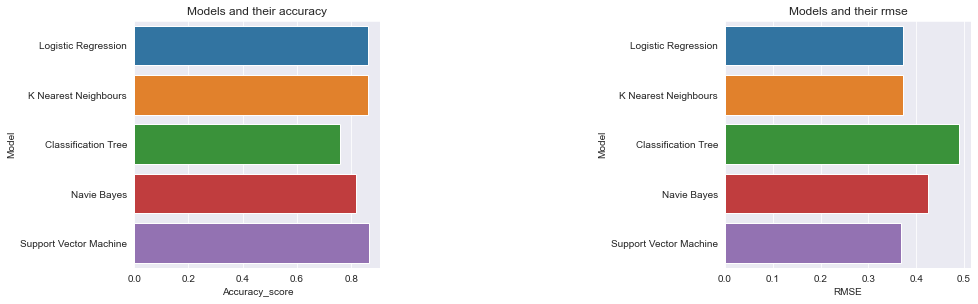

In [149]:
lr = LogisticRegression(random_state=SEED)
kn = KNN(n_neighbors=9, leaf_size=20)
dt = DecisionTreeClassifier(random_state=SEED)
nb = GaussianNB()
SVC = svm.SVC(kernel='rbf', random_state = 42)

lr.fit(X_train, y_train)
kn.fit(X_train, y_train)
dt.fit(X_train, y_train)
nb.fit(X_train, y_train)
SVC.fit(X_train, y_train)

lr_2 = accuracy_score(y_test, lr.predict(X_test))
kn_2 = accuracy_score(y_test, kn.predict(X_test))
dt_2 = accuracy_score(y_test, dt.predict(X_test))
nb_2 = accuracy_score(y_test, nb.predict(X_test))
SVC_2 = accuracy_score(y_test, SVC.predict(X_test))  

lr_rmse = mean_squared_error(y_test, lr.predict(X_test), squared=False)
kn_rmse = mean_squared_error(y_test, kn.predict(X_test), squared=False)
dt_rmse = mean_squared_error(y_test, dt.predict(X_test), squared=False)
nb_rmse = mean_squared_error(y_test, nb.predict(X_test), squared=False)
SVC_rmse = mean_squared_error(y_test, SVC.predict(X_test), squared=False)

#Accuracy score dataframe
models = pd.DataFrame({
    'Model':['Logistic Regression', 'K Nearest Neighbours', 'Classification Tree', 'Navie Bayes','Support Vector Machine'],
    'Accuracy_score':[lr_2, kn_2, dt_2, nb_2, SVC_2],
    'RMSE':[lr_rmse, kn_rmse, dt_rmse,  nb_rmse, SVC_rmse]
})
models

plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
sns.barplot(x='Accuracy_score', y='Model', data=models)
plt.title("Models and their accuracy")

plt.subplot(2,3,3)
sns.barplot(x='RMSE', y='Model', data=models)
plt.title("Models and their rmse")

plt.show()


In [150]:
models.sort_values(by='RMSE', ascending=False)
models.sort_values(by='Accuracy_score', ascending=False)

Model  Accuracy_score      RMSE
4  Support Vector Machine        0.864023  0.368751
0     Logistic Regression        0.861190  0.372572
1    K Nearest Neighbours        0.861190  0.372572
3             Navie Bayes        0.818697  0.425797
2     Classification Tree        0.759207  0.490707